# Bias / Variance analysis
## Airline data analysis with LSTMs

The objective is here to get more insight into the Long Term Short Term Memory Networks (LSTM) and through this simple exaple, understand the concepts of bias and variance,, which are central in any Machine Learning task. We will start by running the code as it was given (I have only added comments for your reference). The exercise was trying (by default) to predict a time series describing the history of the total amount of passengers per month from 1949 to 1960, by predicting the number of passengers from month n from the knowledge of that number at month (n-1) using a LSTM network with 4 units (hidden layer).

In [24]:
# Import libraries required

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers  import LSTM,Bidirectional
from tensorflow.keras.layers import Dense, Activation, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [4]:
# Import data and visualize
data = pd.read_csv("international-airline-passengers.csv", usecols = [1], engine = "python", skipfooter = 3)
print(data.head())
print(data.describe())

   International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0                                                112                             
1                                                118                             
2                                                132                             
3                                                129                             
4                                                121                             
       International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
count                                         144.000000                             
mean                                          280.298611                             
std                                           119.966317                             
min                                           104.000000                             
25%                                           180.000000                      

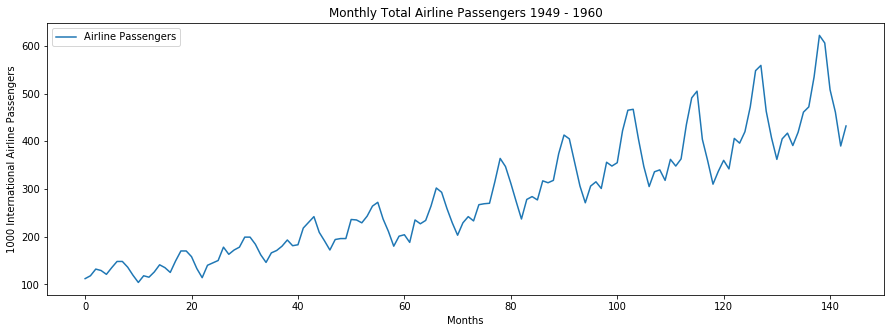

In [5]:
# Create a time series plot.
plt.figure(figsize = (15, 5))
plt.plot(data, label = "Airline Passengers")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Monthly Total Airline Passengers 1949 - 1960")
plt.legend()
plt.show()

The data clearly shows two things: a general increasing trend (polynomial or exponential?) and a seasonality (peaks on summer and lows during winters.

In [7]:
# We scale the data to prepare them to feed the NN
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data)

C:\Users\phili\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Now let's make a split between a train and a dev/test set. The train set will be composed of the first 60% of data, while the test will be on the remaining part. Note that this split looks first challenging, since the test data will not be in the same range of values as the train data (therefore it may be quite challenging to solve this problem...)


In [9]:
TRAIN_SIZE = 0.60
train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (86, 58)


In [10]:
def create_dataset(dataset, window_size = 1):
    """
    Prepares the dataset for analysis. The window size is the number of historical months accounted 
    for by the model to predict the month n+1. The procedure will select the first window_size elements of the list, 
    place them in first pasition of data_X list, use the next element (index = window size) as the first element of list 
    data_Y. Then, it will move on the list dataset by one element and repeat the selection process. This selection 
    will be repeated until the last element of dataset is reached and sent to data_Y.
    """
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

Now let's run the exercise as proposed in the default solution...

In [11]:
# Create test and training sets for one-step-ahead regression.
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(85, 1)
New training data shape:
(85, 1, 1)


The model is built as was proposed, with no changes (LSTM(4) + Dense(1)) and let's use 1000 epochs to train it... Note that I use the additional validation_data keyword...

In [34]:
model = Sequential()
model.add((LSTM(4, input_shape = (1, window_size))))
model.add(Dense(1))
model.compile(loss = "mean_squared_error", optimizer = "adam")
output = model.fit(train_X, train_Y, epochs = 1000,validation_data = (test_X,test_Y))

Train on 85 samples, validate on 57 samples
Epoch 1/1000
85/85 [==============================] - 1s 13ms/sample - loss: 0.0365 - val_loss: 0.2745
Epoch 2/1000
85/85 [==============================] - 0s 82us/sample - loss: 0.0349 - val_loss: 0.2687
Epoch 3/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0333 - val_loss: 0.2630
Epoch 4/1000
85/85 [==============================] - 0s 188us/sample - loss: 0.0318 - val_loss: 0.2573
Epoch 5/1000
85/85 [==============================] - 0s 118us/sample - loss: 0.0303 - val_loss: 0.2517
Epoch 6/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0289 - val_loss: 0.2462
Epoch 7/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0275 - val_loss: 0.2407
Epoch 8/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0262 - val_loss: 0.2352
Epoch 9/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0249 - val_loss: 0.2298
Epoch 10/1000
85/85 [=

85/85 [==============================] - 0s 106us/sample - loss: 0.0068 - val_loss: 0.0880
Epoch 80/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0068 - val_loss: 0.0875
Epoch 81/1000
85/85 [==============================] - 0s 70us/sample - loss: 0.0067 - val_loss: 0.0871
Epoch 82/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0067 - val_loss: 0.0866
Epoch 83/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0067 - val_loss: 0.0862
Epoch 84/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0066 - val_loss: 0.0858
Epoch 85/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0066 - val_loss: 0.0853
Epoch 86/1000
85/85 [==============================] - 0s 141us/sample - loss: 0.0065 - val_loss: 0.0848
Epoch 87/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0065 - val_loss: 0.0843
Epoch 88/1000
85/85 [==============================] - 0s 129us/sample

85/85 [==============================] - 0s 94us/sample - loss: 0.0036 - val_loss: 0.0394
Epoch 157/1000
85/85 [==============================] - 0s 94us/sample - loss: 0.0036 - val_loss: 0.0388
Epoch 158/1000
85/85 [==============================] - 0s 94us/sample - loss: 0.0035 - val_loss: 0.0381
Epoch 159/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0035 - val_loss: 0.0375
Epoch 160/1000
85/85 [==============================] - 0s 141us/sample - loss: 0.0034 - val_loss: 0.0369
Epoch 161/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0034 - val_loss: 0.0363
Epoch 162/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0034 - val_loss: 0.0357
Epoch 163/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0033 - val_loss: 0.0352
Epoch 164/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0033 - val_loss: 0.0346
Epoch 165/1000
85/85 [==============================] - 0s 106us

Epoch 234/1000
85/85 [==============================] - 0s 59us/sample - loss: 0.0018 - val_loss: 0.0111
Epoch 235/1000
85/85 [==============================] - 0s 94us/sample - loss: 0.0018 - val_loss: 0.0110
Epoch 236/1000
85/85 [==============================] - 0s 82us/sample - loss: 0.0018 - val_loss: 0.0110
Epoch 237/1000
85/85 [==============================] - 0s 82us/sample - loss: 0.0018 - val_loss: 0.0108
Epoch 238/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0018 - val_loss: 0.0107
Epoch 239/1000
85/85 [==============================] - 0s 188us/sample - loss: 0.0018 - val_loss: 0.0106
Epoch 240/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0017 - val_loss: 0.0104
Epoch 241/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0017 - val_loss: 0.0103
Epoch 242/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0017 - val_loss: 0.0102
Epoch 243/1000
85/85 [============================

85/85 [==============================] - 0s 94us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 312/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 313/1000
85/85 [==============================] - 0s 94us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 314/1000
85/85 [==============================] - 0s 94us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 315/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 316/1000
85/85 [==============================] - 0s 141us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 317/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 318/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 319/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 320/1000
85/85 [==============================] - 0s 82us/

85/85 [==============================] - 0s 94us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 389/1000
85/85 [==============================] - 0s 94us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 390/1000
85/85 [==============================] - 0s 105us/sample - loss: 0.0016 - val_loss: 0.0079
Epoch 391/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0016 - val_loss: 0.0079
Epoch 392/1000
85/85 [==============================] - 0s 164us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 393/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 394/1000
85/85 [==============================] - 0s 141us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 395/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 396/1000
85/85 [==============================] - 0s 94us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 397/1000
85/85 [==============================] - 0s 129us

85/85 [==============================] - 0s 94us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 466/1000
85/85 [==============================] - 0s 94us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 467/1000
85/85 [==============================] - 0s 94us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 468/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 469/1000
85/85 [==============================] - 0s 141us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 470/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 471/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 472/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 473/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 474/1000
85/85 [==============================] - 0s 106us

85/85 [==============================] - 0s 117us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 543/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 544/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 545/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0079
Epoch 546/1000
85/85 [==============================] - 0s 141us/sample - loss: 0.0016 - val_loss: 0.0079
Epoch 547/1000
85/85 [==============================] - 0s 164us/sample - loss: 0.0016 - val_loss: 0.0079
Epoch 548/1000
85/85 [==============================] - 0s 164us/sample - loss: 0.0016 - val_loss: 0.0079
Epoch 549/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 550/1000
85/85 [==============================] - 0s 188us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 551/1000
85/85 [==============================] - ETA: 

85/85 [==============================] - 0s 94us/sample - loss: 0.0016 - val_loss: 0.0081
Epoch 620/1000
85/85 [==============================] - 0s 94us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 621/1000
85/85 [==============================] - 0s 82us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 622/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 623/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 624/1000
85/85 [==============================] - 0s 141us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 625/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 626/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 627/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0080
Epoch 628/1000
85/85 [==============================] - 0s 117us

85/85 [==============================] - 0s 141us/sample - loss: 0.0016 - val_loss: 0.0081
Epoch 697/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0016 - val_loss: 0.0081
Epoch 698/1000
85/85 [==============================] - 0s 94us/sample - loss: 0.0016 - val_loss: 0.0082
Epoch 699/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0016 - val_loss: 0.0081
Epoch 700/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0016 - val_loss: 0.0081
Epoch 701/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0016 - val_loss: 0.0081
Epoch 702/1000
85/85 [==============================] - 0s 94us/sample - loss: 0.0016 - val_loss: 0.0081
Epoch 703/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0016 - val_loss: 0.0081
Epoch 704/1000
85/85 [==============================] - 0s 141us/sample - loss: 0.0016 - val_loss: 0.0081
Epoch 705/1000
85/85 [==============================] - 0s 129u

85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0083
Epoch 774/1000
85/85 [==============================] - 0s 82us/sample - loss: 0.0016 - val_loss: 0.0083
Epoch 775/1000
85/85 [==============================] - 0s 82us/sample - loss: 0.0016 - val_loss: 0.0082
Epoch 776/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0081
Epoch 777/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0016 - val_loss: 0.0081
Epoch 778/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0016 - val_loss: 0.0081
Epoch 779/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0016 - val_loss: 0.0081
Epoch 780/1000
85/85 [==============================] - 0s 141us/sample - loss: 0.0016 - val_loss: 0.0081
Epoch 781/1000
85/85 [==============================] - 0s 94us/sample - loss: 0.0016 - val_loss: 0.0082
Epoch 782/1000
85/85 [==============================] - 0s 117us

85/85 [==============================] - 0s 117us/sample - loss: 0.0016 - val_loss: 0.0083
Epoch 851/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0083
Epoch 852/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0016 - val_loss: 0.0084
Epoch 853/1000
85/85 [==============================] - 0s 94us/sample - loss: 0.0016 - val_loss: 0.0083
Epoch 854/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0016 - val_loss: 0.0084
Epoch 855/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0016 - val_loss: 0.0084
Epoch 856/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0084
Epoch 857/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0084
Epoch 858/1000
85/85 [==============================] - 0s 141us/sample - loss: 0.0016 - val_loss: 0.0084
Epoch 859/1000
85/85 [==============================] - 0s 153

85/85 [==============================] - 0s 82us/sample - loss: 0.0016 - val_loss: 0.0083
Epoch 928/1000
85/85 [==============================] - 0s 82us/sample - loss: 0.0016 - val_loss: 0.0083
Epoch 929/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0016 - val_loss: 0.0083
Epoch 930/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0016 - val_loss: 0.0084
Epoch 931/1000
85/85 [==============================] - 0s 164us/sample - loss: 0.0016 - val_loss: 0.0084
Epoch 932/1000
85/85 [==============================] - 0s 176us/sample - loss: 0.0016 - val_loss: 0.0085
Epoch 933/1000
85/85 [==============================] - 0s 152us/sample - loss: 0.0016 - val_loss: 0.0085
Epoch 934/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0016 - val_loss: 0.0085
Epoch 935/1000
85/85 [==============================] - 0s 141us/sample - loss: 0.0016 - val_loss: 0.0085
Epoch 936/1000
85/85 [==============================] - 0s 164u

Let's look at the training curves (loss or accuracy depending on the problem vs. epoch)

Text(0.5, 1.0, 'MSE of LSTM model with 1 element of history , and 4 hidden units')

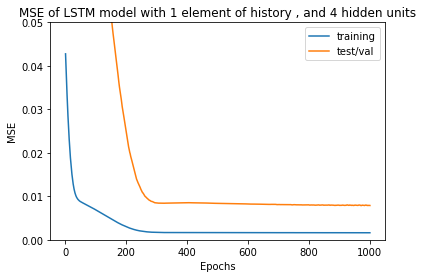

In [20]:
plt.plot(range(1,1001),output.history['loss'],label='training')
plt.plot(range(1,1001),output.history['val_loss'],label='test/val')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.ylim(0,0.05)
plt.title('MSE of LSTM model with 1 element of history , and 4 hidden units')

It looks like we have low bias and higher variance. Then, maybe we could increase the test set size (here not really possible), or regularize the network? 

In [31]:
def predict_and_score(model, scale, X, Y):
    """
    This function takes the fitted model, applies it to X to predict a series, back transforms it to its original scale
    using the scale object and returns finally the mean square error of (predictions - Y)
    """
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

First, let's look these RMSE values. Then we will plot the predictions and expected on the same graph

In [22]:
rmse_train, train_predict = predict_and_score(model, scaler,train_X, train_Y)
rmse_test, test_predict = predict_and_score(model, scaler,test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 20.85 RMSE
Test data score: 46.02 RMSE


In [27]:
model = Sequential()
model.add((LSTM(4, input_shape = (1, window_size),dropout=0.2)))
model.add(Dense(1))
model.compile(loss = "mean_squared_error", optimizer = "adam")
output = model.fit(train_X, train_Y, epochs = 10000,validation_data = (test_X,test_Y))

Train on 85 samples, validate on 57 samples
Epoch 1/10000
85/85 [==============================] - 1s 13ms/sample - loss: 0.0404 - val_loss: 0.2950
Epoch 2/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0370 - val_loss: 0.2876
Epoch 3/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0363 - val_loss: 0.2804
Epoch 4/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0341 - val_loss: 0.2733
Epoch 5/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0325 - val_loss: 0.2663
Epoch 6/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0305 - val_loss: 0.2595
Epoch 7/10000
85/85 [==============================] - 0s 165us/sample - loss: 0.0280 - val_loss: 0.2528
Epoch 8/10000
85/85 [==============================] - 0s 176us/sample - loss: 0.0275 - val_loss: 0.2463
Epoch 9/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0265 - val_loss: 0.2400
Epoch 10/100

85/85 [==============================] - 0s 117us/sample - loss: 0.0093 - val_loss: 0.1062
Epoch 79/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0085 - val_loss: 0.1057
Epoch 80/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0103 - val_loss: 0.1052
Epoch 81/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0090 - val_loss: 0.1046
Epoch 82/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0080 - val_loss: 0.1042
Epoch 83/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0086 - val_loss: 0.1038
Epoch 84/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0086 - val_loss: 0.1034
Epoch 85/10000
85/85 [==============================] - 0s 176us/sample - loss: 0.0090 - val_loss: 0.1030
Epoch 86/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0091 - val_loss: 0.1027
Epoch 87/10000
85/85 [==============================] - 0s 15

Epoch 155/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0075 - val_loss: 0.0773
Epoch 156/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0083 - val_loss: 0.0769
Epoch 157/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0059 - val_loss: 0.0765
Epoch 158/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0079 - val_loss: 0.0763
Epoch 159/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0071 - val_loss: 0.0760
Epoch 160/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0076 - val_loss: 0.0756
Epoch 161/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0088 - val_loss: 0.0752
Epoch 162/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0089 - val_loss: 0.0746
Epoch 163/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0070 - val_loss: 0.0740
Epoch 164/10000
85/85 [===============

85/85 [==============================] - 0s 82us/sample - loss: 0.0067 - val_loss: 0.0571
Epoch 232/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0056 - val_loss: 0.0573
Epoch 233/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0072 - val_loss: 0.0573
Epoch 234/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0083 - val_loss: 0.0571
Epoch 235/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0097 - val_loss: 0.0567
Epoch 236/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0054 - val_loss: 0.0567
Epoch 237/10000
85/85 [==============================] - 0s 176us/sample - loss: 0.0075 - val_loss: 0.0565
Epoch 238/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0081 - val_loss: 0.0564
Epoch 239/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0061 - val_loss: 0.0566
Epoch 240/10000
85/85 [==============================] 

85/85 [==============================] - 0s 94us/sample - loss: 0.0086 - val_loss: 0.0490
Epoch 308/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0060 - val_loss: 0.0487
Epoch 309/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0070 - val_loss: 0.0485
Epoch 310/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0076 - val_loss: 0.0484
Epoch 311/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0050 - val_loss: 0.0485
Epoch 312/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0074 - val_loss: 0.0484
Epoch 313/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0054 - val_loss: 0.0483
Epoch 314/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0080 - val_loss: 0.0481
Epoch 315/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0067 - val_loss: 0.0481
Epoch 316/10000
85/85 [==============================] -

85/85 [==============================] - 0s 94us/sample - loss: 0.0071 - val_loss: 0.0476
Epoch 384/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0048 - val_loss: 0.0476
Epoch 385/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0086 - val_loss: 0.0475
Epoch 386/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0037 - val_loss: 0.0474
Epoch 387/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0062 - val_loss: 0.0472
Epoch 388/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0057 - val_loss: 0.0467
Epoch 389/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0061 - val_loss: 0.0464
Epoch 390/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0060 - val_loss: 0.0462
Epoch 391/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0087 - val_loss: 0.0461
Epoch 392/10000
85/85 [==============================] - 

Epoch 460/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0078 - val_loss: 0.0413
Epoch 461/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0066 - val_loss: 0.0415
Epoch 462/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0068 - val_loss: 0.0415
Epoch 463/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0110 - val_loss: 0.0415
Epoch 464/10000
85/85 [==============================] - 0s 152us/sample - loss: 0.0069 - val_loss: 0.0415
Epoch 465/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0057 - val_loss: 0.0414
Epoch 466/10000
85/85 [==============================] - 0s 152us/sample - loss: 0.0056 - val_loss: 0.0411
Epoch 467/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0049 - val_loss: 0.0407
Epoch 468/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0055 - val_loss: 0.0408
Epoch 469/10000
85/85 [==================

Epoch 537/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0050 - val_loss: 0.0394
Epoch 538/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0077 - val_loss: 0.0396
Epoch 539/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0041 - val_loss: 0.0397
Epoch 540/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0057 - val_loss: 0.0397
Epoch 541/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0069 - val_loss: 0.0397
Epoch 542/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0040 - val_loss: 0.0395
Epoch 543/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0070 - val_loss: 0.0393
Epoch 544/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0076 - val_loss: 0.0392
Epoch 545/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0050 - val_loss: 0.0389
Epoch 546/10000
85/85 [================

Epoch 614/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0044 - val_loss: 0.0369
Epoch 615/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0063 - val_loss: 0.0377
Epoch 616/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0086 - val_loss: 0.0378
Epoch 617/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0062 - val_loss: 0.0374
Epoch 618/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0060 - val_loss: 0.0372
Epoch 619/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0081 - val_loss: 0.0370
Epoch 620/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0058 - val_loss: 0.0367
Epoch 621/10000
85/85 [==============================] - 0s 59us/sample - loss: 0.0072 - val_loss: 0.0366
Epoch 622/10000
85/85 [==============================] - 0s 59us/sample - loss: 0.0070 - val_loss: 0.0361
Epoch 623/10000
85/85 [=====================

Epoch 691/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0061 - val_loss: 0.0331
Epoch 692/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0055 - val_loss: 0.0333
Epoch 693/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0054 - val_loss: 0.0330
Epoch 694/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0073 - val_loss: 0.0328
Epoch 695/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0060 - val_loss: 0.0327
Epoch 696/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0053 - val_loss: 0.0326
Epoch 697/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0054 - val_loss: 0.0322
Epoch 698/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0053 - val_loss: 0.0321
Epoch 699/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0054 - val_loss: 0.0318
Epoch 700/10000
85/85 [==================

Epoch 768/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0062 - val_loss: 0.0300
Epoch 769/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0048 - val_loss: 0.0298
Epoch 770/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0046 - val_loss: 0.0301
Epoch 771/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0072 - val_loss: 0.0302
Epoch 772/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0041 - val_loss: 0.0306
Epoch 773/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0046 - val_loss: 0.0309
Epoch 774/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0053 - val_loss: 0.0312
Epoch 775/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0075 - val_loss: 0.0310
Epoch 776/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0049 - val_loss: 0.0306
Epoch 777/10000
85/85 [================

Epoch 845/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0064 - val_loss: 0.0256
Epoch 846/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0045 - val_loss: 0.0253
Epoch 847/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0049 - val_loss: 0.0255
Epoch 848/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0045 - val_loss: 0.0252
Epoch 849/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0070 - val_loss: 0.0247
Epoch 850/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0052 - val_loss: 0.0243
Epoch 851/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0058 - val_loss: 0.0242
Epoch 852/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0068 - val_loss: 0.0240
Epoch 853/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0052 - val_loss: 0.0239
Epoch 854/10000
85/85 [=================

Epoch 922/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0049 - val_loss: 0.0224
Epoch 923/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0063 - val_loss: 0.0228
Epoch 924/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0055 - val_loss: 0.0228
Epoch 925/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0045 - val_loss: 0.0226
Epoch 926/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0057 - val_loss: 0.0226
Epoch 927/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0059 - val_loss: 0.0223
Epoch 928/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0042 - val_loss: 0.0222
Epoch 929/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0049 - val_loss: 0.0219
Epoch 930/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0047 - val_loss: 0.0216
Epoch 931/10000
85/85 [================

Epoch 999/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0047 - val_loss: 0.0203
Epoch 1000/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0052 - val_loss: 0.0203
Epoch 1001/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0053 - val_loss: 0.0203
Epoch 1002/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0041 - val_loss: 0.0206
Epoch 1003/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0043 - val_loss: 0.0208
Epoch 1004/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0053 - val_loss: 0.0204
Epoch 1005/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0053 - val_loss: 0.0197
Epoch 1006/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0050 - val_loss: 0.0193
Epoch 1007/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0044 - val_loss: 0.0193
Epoch 1008/10000
85/85 [=======

85/85 [==============================] - 0s 94us/sample - loss: 0.0040 - val_loss: 0.0195
Epoch 1076/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0048 - val_loss: 0.0192
Epoch 1077/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0038 - val_loss: 0.0196
Epoch 1078/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0056 - val_loss: 0.0200
Epoch 1079/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0040 - val_loss: 0.0207
Epoch 1080/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0039 - val_loss: 0.0213
Epoch 1081/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0064 - val_loss: 0.0213
Epoch 1082/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0054 - val_loss: 0.0207
Epoch 1083/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0036 - val_loss: 0.0203
Epoch 1084/10000
85/85 [========================

85/85 [==============================] - 0s 94us/sample - loss: 0.0048 - val_loss: 0.0177
Epoch 1152/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0047 - val_loss: 0.0185
Epoch 1153/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0047 - val_loss: 0.0193
Epoch 1154/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0038 - val_loss: 0.0196
Epoch 1155/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0044 - val_loss: 0.0198
Epoch 1156/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0050 - val_loss: 0.0196
Epoch 1157/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0048 - val_loss: 0.0189
Epoch 1158/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0042 - val_loss: 0.0183
Epoch 1159/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0043 - val_loss: 0.0176
Epoch 1160/10000
85/85 [=======================

85/85 [==============================] - 0s 82us/sample - loss: 0.0058 - val_loss: 0.0187
Epoch 1228/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0040 - val_loss: 0.0185
Epoch 1229/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0046 - val_loss: 0.0182
Epoch 1230/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0039 - val_loss: 0.0181
Epoch 1231/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0045 - val_loss: 0.0180
Epoch 1232/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0036 - val_loss: 0.0182
Epoch 1233/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0043 - val_loss: 0.0186
Epoch 1234/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0044 - val_loss: 0.0192
Epoch 1235/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0043 - val_loss: 0.0199
Epoch 1236/10000
85/85 [=========================

85/85 [==============================] - 0s 106us/sample - loss: 0.0040 - val_loss: 0.0186
Epoch 1304/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0047 - val_loss: 0.0185
Epoch 1305/10000
85/85 [==============================] - 0s 105us/sample - loss: 0.0066 - val_loss: 0.0177
Epoch 1306/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0040 - val_loss: 0.0175
Epoch 1307/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0043 - val_loss: 0.0177
Epoch 1308/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0043 - val_loss: 0.0175
Epoch 1309/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0053 - val_loss: 0.0172
Epoch 1310/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0040 - val_loss: 0.0174
Epoch 1311/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0042 - val_loss: 0.0180
Epoch 1312/10000
85/85 [=======================

85/85 [==============================] - 0s 59us/sample - loss: 0.0034 - val_loss: 0.0204
Epoch 1380/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0037 - val_loss: 0.0203
Epoch 1381/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0037 - val_loss: 0.0198
Epoch 1382/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0042 - val_loss: 0.0195
Epoch 1383/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0048 - val_loss: 0.0195
Epoch 1384/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0052 - val_loss: 0.0189
Epoch 1385/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0045 - val_loss: 0.0183
Epoch 1386/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0035 - val_loss: 0.0182
Epoch 1387/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0040 - val_loss: 0.0179
Epoch 1388/10000
85/85 [========================

85/85 [==============================] - 0s 94us/sample - loss: 0.0053 - val_loss: 0.0194
Epoch 1456/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0056 - val_loss: 0.0201
Epoch 1457/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0057 - val_loss: 0.0206
Epoch 1458/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0033 - val_loss: 0.0214
Epoch 1459/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0041 - val_loss: 0.0221
Epoch 1460/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0031 - val_loss: 0.0229
Epoch 1461/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0069 - val_loss: 0.0230
Epoch 1462/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0039 - val_loss: 0.0227
Epoch 1463/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0024 - val_loss: 0.0227
Epoch 1464/10000
85/85 [========================

85/85 [==============================] - 0s 94us/sample - loss: 0.0046 - val_loss: 0.0207
Epoch 1532/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0033 - val_loss: 0.0209
Epoch 1533/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0043 - val_loss: 0.0213
Epoch 1534/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0054 - val_loss: 0.0219
Epoch 1535/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0037 - val_loss: 0.0224
Epoch 1536/10000
85/85 [==============================] - 0s 152us/sample - loss: 0.0060 - val_loss: 0.0224
Epoch 1537/10000
85/85 [==============================] - 0s 152us/sample - loss: 0.0043 - val_loss: 0.0226
Epoch 1538/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0053 - val_loss: 0.0224
Epoch 1539/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0049 - val_loss: 0.0217
Epoch 1540/10000
85/85 [===========================

85/85 [==============================] - 0s 94us/sample - loss: 0.0039 - val_loss: 0.0229
Epoch 1608/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0047 - val_loss: 0.0217
Epoch 1609/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0048 - val_loss: 0.0212
Epoch 1610/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0057 - val_loss: 0.0215
Epoch 1611/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0047 - val_loss: 0.0221
Epoch 1612/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0042 - val_loss: 0.0223
Epoch 1613/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0047 - val_loss: 0.0222
Epoch 1614/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0050 - val_loss: 0.0221
Epoch 1615/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0035 - val_loss: 0.0223
Epoch 1616/10000
85/85 [========================

85/85 [==============================] - 0s 82us/sample - loss: 0.0037 - val_loss: 0.0247
Epoch 1684/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0050 - val_loss: 0.0251
Epoch 1685/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0045 - val_loss: 0.0253
Epoch 1686/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0033 - val_loss: 0.0253
Epoch 1687/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0031 - val_loss: 0.0256
Epoch 1688/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0049 - val_loss: 0.0258
Epoch 1689/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0048 - val_loss: 0.0253
Epoch 1690/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0028 - val_loss: 0.0259
Epoch 1691/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0042 - val_loss: 0.0274
Epoch 1692/10000
85/85 [=========================

Epoch 1759/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0040 - val_loss: 0.0308
Epoch 1760/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0037 - val_loss: 0.0310
Epoch 1761/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0038 - val_loss: 0.0310
Epoch 1762/10000
85/85 [==============================] - ETA: 0s - loss: 0.004 - 0s 129us/sample - loss: 0.0043 - val_loss: 0.0307
Epoch 1763/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0046 - val_loss: 0.0300
Epoch 1764/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0041 - val_loss: 0.0293
Epoch 1765/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0026 - val_loss: 0.0298
Epoch 1766/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0049 - val_loss: 0.0295
Epoch 1767/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0030 - val_loss: 0.0292
Epoch 

85/85 [==============================] - 0s 82us/sample - loss: 0.0046 - val_loss: 0.0322
Epoch 1835/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0032 - val_loss: 0.0331
Epoch 1836/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0046 - val_loss: 0.0337
Epoch 1837/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0047 - val_loss: 0.0340
Epoch 1838/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0069 - val_loss: 0.0342
Epoch 1839/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0036 - val_loss: 0.0341
Epoch 1840/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0034 - val_loss: 0.0342
Epoch 1841/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0048 - val_loss: 0.0334
Epoch 1842/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0038 - val_loss: 0.0321
Epoch 1843/10000
85/85 [=======================

85/85 [==============================] - 0s 82us/sample - loss: 0.0045 - val_loss: 0.0384
Epoch 1911/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0030 - val_loss: 0.0387
Epoch 1912/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0031 - val_loss: 0.0388
Epoch 1913/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0046 - val_loss: 0.0381
Epoch 1914/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0048 - val_loss: 0.0375
Epoch 1915/10000
85/85 [==============================] - ETA: 0s - loss: 0.003 - 0s 164us/sample - loss: 0.0051 - val_loss: 0.0369
Epoch 1916/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0039 - val_loss: 0.0359
Epoch 1917/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0028 - val_loss: 0.0353
Epoch 1918/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0041 - val_loss: 0.0350
Epoch 1919/10000
85/85 [=

85/85 [==============================] - 0s 82us/sample - loss: 0.0034 - val_loss: 0.0383
Epoch 1987/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0038 - val_loss: 0.0391
Epoch 1988/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0034 - val_loss: 0.0395
Epoch 1989/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0051 - val_loss: 0.0387
Epoch 1990/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0033 - val_loss: 0.0384
Epoch 1991/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0035 - val_loss: 0.0378
Epoch 1992/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0032 - val_loss: 0.0373
Epoch 1993/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0033 - val_loss: 0.0375
Epoch 1994/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0034 - val_loss: 0.0383
Epoch 1995/10000
85/85 [=======================

85/85 [==============================] - 0s 94us/sample - loss: 0.0057 - val_loss: 0.0395
Epoch 2063/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0052 - val_loss: 0.0391
Epoch 2064/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0041 - val_loss: 0.0391
Epoch 2065/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0037 - val_loss: 0.0406
Epoch 2066/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0031 - val_loss: 0.0423
Epoch 2067/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0041 - val_loss: 0.0441
Epoch 2068/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0033 - val_loss: 0.0449
Epoch 2069/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0036 - val_loss: 0.0453
Epoch 2070/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0030 - val_loss: 0.0454
Epoch 2071/10000
85/85 [========================

85/85 [==============================] - 0s 117us/sample - loss: 0.0041 - val_loss: 0.0455
Epoch 2139/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0036 - val_loss: 0.0467
Epoch 2140/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0035 - val_loss: 0.0472
Epoch 2141/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0029 - val_loss: 0.0468
Epoch 2142/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0033 - val_loss: 0.0465
Epoch 2143/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0035 - val_loss: 0.0462
Epoch 2144/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0034 - val_loss: 0.0459
Epoch 2145/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0049 - val_loss: 0.0455
Epoch 2146/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0031 - val_loss: 0.0449
Epoch 2147/10000
85/85 [========================

85/85 [==============================] - 0s 94us/sample - loss: 0.0032 - val_loss: 0.0504
Epoch 2215/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0033 - val_loss: 0.0502
Epoch 2216/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0034 - val_loss: 0.0504
Epoch 2217/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0036 - val_loss: 0.0503
Epoch 2218/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0030 - val_loss: 0.0505
Epoch 2219/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0036 - val_loss: 0.0509
Epoch 2220/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0028 - val_loss: 0.0518
Epoch 2221/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0036 - val_loss: 0.0526
Epoch 2222/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0040 - val_loss: 0.0532
Epoch 2223/10000
85/85 [=========================

85/85 [==============================] - 0s 82us/sample - loss: 0.0041 - val_loss: 0.0528
Epoch 2291/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0035 - val_loss: 0.0529
Epoch 2292/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0039 - val_loss: 0.0525
Epoch 2293/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0036 - val_loss: 0.0514
Epoch 2294/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0045 - val_loss: 0.0501
Epoch 2295/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0028 - val_loss: 0.0503
Epoch 2296/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0036 - val_loss: 0.0509
Epoch 2297/10000
85/85 [==============================] - 0s 152us/sample - loss: 0.0030 - val_loss: 0.0522
Epoch 2298/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0027 - val_loss: 0.0536
Epoch 2299/10000
85/85 [========================

85/85 [==============================] - 0s 94us/sample - loss: 0.0032 - val_loss: 0.0538
Epoch 2367/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0043 - val_loss: 0.0532
Epoch 2368/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0038 - val_loss: 0.0527
Epoch 2369/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0048 - val_loss: 0.0523
Epoch 2370/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0031 - val_loss: 0.0531
Epoch 2371/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0036 - val_loss: 0.0546
Epoch 2372/10000
85/85 [==============================] - 0s 152us/sample - loss: 0.0027 - val_loss: 0.0560
Epoch 2373/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0039 - val_loss: 0.0573
Epoch 2374/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0032 - val_loss: 0.0584
Epoch 2375/10000
85/85 [========================

Epoch 2442/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0045 - val_loss: 0.0609
Epoch 2443/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0029 - val_loss: 0.0601
Epoch 2444/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0032 - val_loss: 0.0593
Epoch 2445/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0039 - val_loss: 0.0578
Epoch 2446/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0039 - val_loss: 0.0563
Epoch 2447/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0034 - val_loss: 0.0552
Epoch 2448/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0042 - val_loss: 0.0550
Epoch 2449/10000
85/85 [==============================] - 0s 152us/sample - loss: 0.0034 - val_loss: 0.0555
Epoch 2450/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0030 - val_loss: 0.0565
Epoch 2451/10000
85/85 [=======

85/85 [==============================] - 0s 106us/sample - loss: 0.0044 - val_loss: 0.0558
Epoch 2519/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0039 - val_loss: 0.0545
Epoch 2520/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0028 - val_loss: 0.0541
Epoch 2521/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0034 - val_loss: 0.0540
Epoch 2522/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0034 - val_loss: 0.0537
Epoch 2523/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0033 - val_loss: 0.0533
Epoch 2524/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0036 - val_loss: 0.0536
Epoch 2525/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0038 - val_loss: 0.0540
Epoch 2526/10000
85/85 [==============================] - 0s 152us/sample - loss: 0.0030 - val_loss: 0.0545
Epoch 2527/10000
85/85 [=======================

85/85 [==============================] - 0s 94us/sample - loss: 0.0038 - val_loss: 0.0576
Epoch 2595/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0038 - val_loss: 0.0582
Epoch 2596/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0037 - val_loss: 0.0583
Epoch 2597/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0028 - val_loss: 0.0581
Epoch 2598/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0037 - val_loss: 0.0583
Epoch 2599/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0036 - val_loss: 0.0574
Epoch 2600/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0035 - val_loss: 0.0575
Epoch 2601/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0024 - val_loss: 0.0585
Epoch 2602/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0033 - val_loss: 0.0590
Epoch 2603/10000
85/85 [=========================

Epoch 2670/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0021 - val_loss: 0.0619
Epoch 2671/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0056 - val_loss: 0.0618
Epoch 2672/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0027 - val_loss: 0.0626
Epoch 2673/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0051 - val_loss: 0.0621
Epoch 2674/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0037 - val_loss: 0.0606
Epoch 2675/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0034 - val_loss: 0.0601
Epoch 2676/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0025 - val_loss: 0.0605
Epoch 2677/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0031 - val_loss: 0.0608
Epoch 2678/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0031 - val_loss: 0.0609
Epoch 2679/10000
85/85 [========

85/85 [==============================] - 0s 82us/sample - loss: 0.0047 - val_loss: 0.0595
Epoch 2747/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0039 - val_loss: 0.0602
Epoch 2748/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0042 - val_loss: 0.0603
Epoch 2749/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0034 - val_loss: 0.0606
Epoch 2750/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0040 - val_loss: 0.0610
Epoch 2751/10000
85/85 [==============================] - 0s 176us/sample - loss: 0.0052 - val_loss: 0.0604
Epoch 2752/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0045 - val_loss: 0.0593
Epoch 2753/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0034 - val_loss: 0.0574
Epoch 2754/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0037 - val_loss: 0.0564
Epoch 2755/10000
85/85 [========================

85/85 [==============================] - 0s 106us/sample - loss: 0.0039 - val_loss: 0.0589
Epoch 2823/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0023 - val_loss: 0.0593
Epoch 2824/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0035 - val_loss: 0.0598
Epoch 2825/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0034 - val_loss: 0.0608
Epoch 2826/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0035 - val_loss: 0.0613
Epoch 2827/10000
85/85 [==============================] - 0s 188us/sample - loss: 0.0026 - val_loss: 0.0622
Epoch 2828/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0036 - val_loss: 0.0617
Epoch 2829/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0031 - val_loss: 0.0607
Epoch 2830/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0035 - val_loss: 0.0596
Epoch 2831/10000
85/85 [=======================

85/85 [==============================] - 0s 94us/sample - loss: 0.0035 - val_loss: 0.0624
Epoch 2899/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0046 - val_loss: 0.0620
Epoch 2900/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0037 - val_loss: 0.0613
Epoch 2901/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0021 - val_loss: 0.0614
Epoch 2902/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0033 - val_loss: 0.0620
Epoch 2903/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0038 - val_loss: 0.0619
Epoch 2904/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0042 - val_loss: 0.0618
Epoch 2905/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0047 - val_loss: 0.0616
Epoch 2906/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0039 - val_loss: 0.0618
Epoch 2907/10000
85/85 [========================

85/85 [==============================] - 0s 94us/sample - loss: 0.0070 - val_loss: 0.0651
Epoch 2975/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0035 - val_loss: 0.0630
Epoch 2976/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0036 - val_loss: 0.0608
Epoch 2977/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0042 - val_loss: 0.0597
Epoch 2978/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0047 - val_loss: 0.0601
Epoch 2979/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0036 - val_loss: 0.0613
Epoch 2980/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0034 - val_loss: 0.0624
Epoch 2981/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0031 - val_loss: 0.0629
Epoch 2982/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0039 - val_loss: 0.0635
Epoch 2983/10000
85/85 [=========================

85/85 [==============================] - 0s 94us/sample - loss: 0.0051 - val_loss: 0.0637
Epoch 3051/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0046 - val_loss: 0.0632
Epoch 3052/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0040 - val_loss: 0.0623
Epoch 3053/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0034 - val_loss: 0.0618
Epoch 3054/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0034 - val_loss: 0.0615
Epoch 3055/10000
85/85 [==============================] - 0s 140us/sample - loss: 0.0039 - val_loss: 0.0613
Epoch 3056/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0038 - val_loss: 0.0608
Epoch 3057/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0043 - val_loss: 0.0608
Epoch 3058/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0025 - val_loss: 0.0608
Epoch 3059/10000
85/85 [==========================

Epoch 3126/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0046 - val_loss: 0.0649
Epoch 3127/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0024 - val_loss: 0.0641
Epoch 3128/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0038 - val_loss: 0.0635
Epoch 3129/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0046 - val_loss: 0.0625
Epoch 3130/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0039 - val_loss: 0.0616
Epoch 3131/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0050 - val_loss: 0.0614
Epoch 3132/10000
85/85 [==============================] - 0s 118us/sample - loss: 0.0037 - val_loss: 0.0617
Epoch 3133/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0028 - val_loss: 0.0631
Epoch 3134/10000
85/85 [==============================] - 0s 152us/sample - loss: 0.0038 - val_loss: 0.0640
Epoch 3135/10000
85/85 [======

Epoch 3202/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0041 - val_loss: 0.0621
Epoch 3203/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0036 - val_loss: 0.0613
Epoch 3204/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0059 - val_loss: 0.0608
Epoch 3205/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0044 - val_loss: 0.0619
Epoch 3206/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0032 - val_loss: 0.0647
Epoch 3207/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0029 - val_loss: 0.0671
Epoch 3208/10000
85/85 [==============================] - 0s 188us/sample - loss: 0.0059 - val_loss: 0.0687
Epoch 3209/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0028 - val_loss: 0.0691
Epoch 3210/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0035 - val_loss: 0.0691
Epoch 3211/10000
85/85 [=====

85/85 [==============================] - 0s 94us/sample - loss: 0.0060 - val_loss: 0.0613
Epoch 3279/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0038 - val_loss: 0.0609
Epoch 3280/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0047 - val_loss: 0.0610
Epoch 3281/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0056 - val_loss: 0.0605
Epoch 3282/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0043 - val_loss: 0.0606
Epoch 3283/10000
85/85 [==============================] - 0s 176us/sample - loss: 0.0038 - val_loss: 0.0613
Epoch 3284/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0033 - val_loss: 0.0625
Epoch 3285/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0032 - val_loss: 0.0629
Epoch 3286/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0039 - val_loss: 0.0632
Epoch 3287/10000
85/85 [========================

85/85 [==============================] - 0s 106us/sample - loss: 0.0025 - val_loss: 0.0578
Epoch 3355/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0046 - val_loss: 0.0585
Epoch 3356/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0035 - val_loss: 0.0591
Epoch 3357/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0044 - val_loss: 0.0591
Epoch 3358/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0029 - val_loss: 0.0591
Epoch 3359/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0046 - val_loss: 0.0594
Epoch 3360/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0044 - val_loss: 0.0593
Epoch 3361/10000
85/85 [==============================] - 0s 176us/sample - loss: 0.0031 - val_loss: 0.0590
Epoch 3362/10000
85/85 [==============================] - 0s 199us/sample - loss: 0.0043 - val_loss: 0.0601
Epoch 3363/10000
85/85 [=======================

85/85 [==============================] - 0s 94us/sample - loss: 0.0029 - val_loss: 0.0595
Epoch 3431/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0038 - val_loss: 0.0589
Epoch 3432/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0048 - val_loss: 0.0591
Epoch 3433/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0044 - val_loss: 0.0604
Epoch 3434/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0033 - val_loss: 0.0618
Epoch 3435/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0043 - val_loss: 0.0626
Epoch 3436/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0048 - val_loss: 0.0632
Epoch 3437/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0032 - val_loss: 0.0638
Epoch 3438/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0046 - val_loss: 0.0645
Epoch 3439/10000
85/85 [========================

Epoch 3506/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0040 - val_loss: 0.0670
Epoch 3507/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0028 - val_loss: 0.0674
Epoch 3508/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0044 - val_loss: 0.0674
Epoch 3509/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0036 - val_loss: 0.0672
Epoch 3510/10000
85/85 [==============================] - 0s 176us/sample - loss: 0.0043 - val_loss: 0.0662
Epoch 3511/10000
85/85 [==============================] - 0s 176us/sample - loss: 0.0033 - val_loss: 0.0643
Epoch 3512/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0034 - val_loss: 0.0622
Epoch 3513/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0039 - val_loss: 0.0610
Epoch 3514/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0040 - val_loss: 0.0597
Epoch 3515/10000
85/85 [=====

Epoch 3582/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0046 - val_loss: 0.0616
Epoch 3583/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0036 - val_loss: 0.0614
Epoch 3584/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0040 - val_loss: 0.0618
Epoch 3585/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0045 - val_loss: 0.0626
Epoch 3586/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0027 - val_loss: 0.0640
Epoch 3587/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0032 - val_loss: 0.0657
Epoch 3588/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0035 - val_loss: 0.0668
Epoch 3589/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0034 - val_loss: 0.0679
Epoch 3590/10000
85/85 [==============================] - 0s 152us/sample - loss: 0.0039 - val_loss: 0.0688
Epoch 3591/10000
85/85 [=====

85/85 [==============================] - 0s 117us/sample - loss: 0.0037 - val_loss: 0.0623
Epoch 3658/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0037 - val_loss: 0.0634
Epoch 3659/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0031 - val_loss: 0.0635
Epoch 3660/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0028 - val_loss: 0.0641
Epoch 3661/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0027 - val_loss: 0.0644
Epoch 3662/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0035 - val_loss: 0.0644
Epoch 3663/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0039 - val_loss: 0.0641
Epoch 3664/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0036 - val_loss: 0.0637
Epoch 3665/10000
85/85 [==============================] - 0s 176us/sample - loss: 0.0022 - val_loss: 0.0631
Epoch 3666/10000
85/85 [========================

85/85 [==============================] - 0s 117us/sample - loss: 0.0045 - val_loss: 0.0607
Epoch 3734/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0033 - val_loss: 0.0622
Epoch 3735/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0030 - val_loss: 0.0643
Epoch 3736/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0031 - val_loss: 0.0657
Epoch 3737/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0039 - val_loss: 0.0670
Epoch 3738/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0051 - val_loss: 0.0672
Epoch 3739/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0020 - val_loss: 0.0672
Epoch 3740/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0028 - val_loss: 0.0668
Epoch 3741/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0033 - val_loss: 0.0655
Epoch 3742/10000
85/85 [======================

85/85 [==============================] - 0s 94us/sample - loss: 0.0029 - val_loss: 0.0633
Epoch 3810/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0023 - val_loss: 0.0635
Epoch 3811/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0032 - val_loss: 0.0635
Epoch 3812/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0040 - val_loss: 0.0623
Epoch 3813/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0029 - val_loss: 0.0616
Epoch 3814/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0041 - val_loss: 0.0605
Epoch 3815/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0032 - val_loss: 0.0599
Epoch 3816/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0042 - val_loss: 0.0594
Epoch 3817/10000
85/85 [==============================] - 0s 176us/sample - loss: 0.0043 - val_loss: 0.0594
Epoch 3818/10000
85/85 [=========================

85/85 [==============================] - 0s 106us/sample - loss: 0.0028 - val_loss: 0.0628
Epoch 3886/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0046 - val_loss: 0.0646
Epoch 3887/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0037 - val_loss: 0.0669
Epoch 3888/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0035 - val_loss: 0.0683
Epoch 3889/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0040 - val_loss: 0.0691
Epoch 3890/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0039 - val_loss: 0.0682
Epoch 3891/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0026 - val_loss: 0.0668
Epoch 3892/10000
85/85 [==============================] - 0s 165us/sample - loss: 0.0049 - val_loss: 0.0655
Epoch 3893/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0048 - val_loss: 0.0641
Epoch 3894/10000
85/85 [======================

85/85 [==============================] - 0s 94us/sample - loss: 0.0070 - val_loss: 0.0639
Epoch 3962/10000
85/85 [==============================] - 0s 199us/sample - loss: 0.0032 - val_loss: 0.0632
Epoch 3963/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0032 - val_loss: 0.0633
Epoch 3964/10000
85/85 [==============================] - 0s 105us/sample - loss: 0.0039 - val_loss: 0.0637
Epoch 3965/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0034 - val_loss: 0.0635
Epoch 3966/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0039 - val_loss: 0.0637
Epoch 3967/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0038 - val_loss: 0.0634
Epoch 3968/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0033 - val_loss: 0.0634
Epoch 3969/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0028 - val_loss: 0.0644
Epoch 3970/10000
85/85 [========================

85/85 [==============================] - 0s 94us/sample - loss: 0.0030 - val_loss: 0.0671
Epoch 4038/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0031 - val_loss: 0.0675
Epoch 4039/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0049 - val_loss: 0.0672
Epoch 4040/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0039 - val_loss: 0.0670
Epoch 4041/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0035 - val_loss: 0.0672
Epoch 4042/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0033 - val_loss: 0.0672
Epoch 4043/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0035 - val_loss: 0.0667
Epoch 4044/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0033 - val_loss: 0.0668
Epoch 4045/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0027 - val_loss: 0.0674
Epoch 4046/10000
85/85 [========================

85/85 [==============================] - 0s 106us/sample - loss: 0.0066 - val_loss: 0.0657
Epoch 4114/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0024 - val_loss: 0.0649
Epoch 4115/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0031 - val_loss: 0.0634
Epoch 4116/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0034 - val_loss: 0.0620
Epoch 4117/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0034 - val_loss: 0.0615
Epoch 4118/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0032 - val_loss: 0.0617
Epoch 4119/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0036 - val_loss: 0.0619
Epoch 4120/10000
85/85 [==============================] - 0s 188us/sample - loss: 0.0035 - val_loss: 0.0623
Epoch 4121/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0030 - val_loss: 0.0622
Epoch 4122/10000
85/85 [=======================

Epoch 4189/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0028 - val_loss: 0.0646
Epoch 4190/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0030 - val_loss: 0.0645
Epoch 4191/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0030 - val_loss: 0.0640
Epoch 4192/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0023 - val_loss: 0.0633
Epoch 4193/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0028 - val_loss: 0.0628
Epoch 4194/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0025 - val_loss: 0.0626
Epoch 4195/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0038 - val_loss: 0.0626
Epoch 4196/10000
85/85 [==============================] - 0s 176us/sample - loss: 0.0032 - val_loss: 0.0622
Epoch 4197/10000
85/85 [==============================] - 0s 176us/sample - loss: 0.0030 - val_loss: 0.0618
Epoch 4198/10000
85/85 [=====

Epoch 4265/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0030 - val_loss: 0.0659
Epoch 4266/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0024 - val_loss: 0.0646
Epoch 4267/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0049 - val_loss: 0.0639
Epoch 4268/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0027 - val_loss: 0.0635
Epoch 4269/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0041 - val_loss: 0.0635
Epoch 4270/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0048 - val_loss: 0.0639
Epoch 4271/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0025 - val_loss: 0.0649
Epoch 4272/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0033 - val_loss: 0.0656
Epoch 4273/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0044 - val_loss: 0.0657
Epoch 4274/10000
85/85 [======

Epoch 4341/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0036 - val_loss: 0.0694
Epoch 4342/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0028 - val_loss: 0.0703
Epoch 4343/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0037 - val_loss: 0.0698
Epoch 4344/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0044 - val_loss: 0.0687
Epoch 4345/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0031 - val_loss: 0.0674
Epoch 4346/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0069 - val_loss: 0.0666
Epoch 4347/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0056 - val_loss: 0.0648
Epoch 4348/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0029 - val_loss: 0.0638
Epoch 4349/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0040 - val_loss: 0.0639
Epoch 4350/10000
85/85 [=========

85/85 [==============================] - 0s 117us/sample - loss: 0.0049 - val_loss: 0.0666
Epoch 4418/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0036 - val_loss: 0.0663
Epoch 4419/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0033 - val_loss: 0.0661
Epoch 4420/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0031 - val_loss: 0.0661
Epoch 4421/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0039 - val_loss: 0.0664
Epoch 4422/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0061 - val_loss: 0.0665
Epoch 4423/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0050 - val_loss: 0.0660
Epoch 4424/10000
85/85 [==============================] - 0s 152us/sample - loss: 0.0039 - val_loss: 0.0663
Epoch 4425/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0031 - val_loss: 0.0661
Epoch 4426/10000
85/85 [========================

85/85 [==============================] - 0s 106us/sample - loss: 0.0034 - val_loss: 0.0688
Epoch 4494/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0041 - val_loss: 0.0676
Epoch 4495/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0036 - val_loss: 0.0658
Epoch 4496/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0035 - val_loss: 0.0640
Epoch 4497/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0031 - val_loss: 0.0633
Epoch 4498/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0033 - val_loss: 0.0634
Epoch 4499/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0039 - val_loss: 0.0643
Epoch 4500/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0041 - val_loss: 0.0650
Epoch 4501/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0032 - val_loss: 0.0664
Epoch 4502/10000
85/85 [=======================

85/85 [==============================] - 0s 106us/sample - loss: 0.0051 - val_loss: 0.0665
Epoch 4570/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0031 - val_loss: 0.0657
Epoch 4571/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0024 - val_loss: 0.0658
Epoch 4572/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0032 - val_loss: 0.0664
Epoch 4573/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0032 - val_loss: 0.0677
Epoch 4574/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0044 - val_loss: 0.0675
Epoch 4575/10000
85/85 [==============================] - 0s 176us/sample - loss: 0.0040 - val_loss: 0.0674
Epoch 4576/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0026 - val_loss: 0.0667
Epoch 4577/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0029 - val_loss: 0.0664
Epoch 4578/10000
85/85 [=======================

85/85 [==============================] - 0s 106us/sample - loss: 0.0031 - val_loss: 0.0667
Epoch 4646/10000
85/85 [==============================] - ETA: 0s - loss: 0.003 - 0s 129us/sample - loss: 0.0041 - val_loss: 0.0658
Epoch 4647/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0021 - val_loss: 0.0660
Epoch 4648/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0037 - val_loss: 0.0660
Epoch 4649/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0024 - val_loss: 0.0656
Epoch 4650/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0029 - val_loss: 0.0650
Epoch 4651/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0033 - val_loss: 0.0651
Epoch 4652/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0030 - val_loss: 0.0654
Epoch 4653/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0045 - val_loss: 0.0647
Epoch 4654/10000
85/85 

Epoch 4721/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0042 - val_loss: 0.0694
Epoch 4722/10000
85/85 [==============================] - ETA: 0s - loss: 0.002 - 0s 94us/sample - loss: 0.0022 - val_loss: 0.0702
Epoch 4723/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0032 - val_loss: 0.0700
Epoch 4724/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0049 - val_loss: 0.0691
Epoch 4725/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0062 - val_loss: 0.0672
Epoch 4726/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0033 - val_loss: 0.0659
Epoch 4727/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0034 - val_loss: 0.0653
Epoch 4728/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0039 - val_loss: 0.0661
Epoch 4729/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0028 - val_loss: 0.0677
Epoch

85/85 [==============================] - 0s 94us/sample - loss: 0.0055 - val_loss: 0.0664
Epoch 4797/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0024 - val_loss: 0.0656
Epoch 4798/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0038 - val_loss: 0.0651
Epoch 4799/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0033 - val_loss: 0.0656
Epoch 4800/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0031 - val_loss: 0.0653
Epoch 4801/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0027 - val_loss: 0.0659
Epoch 4802/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0053 - val_loss: 0.0659
Epoch 4803/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0030 - val_loss: 0.0662
Epoch 4804/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0038 - val_loss: 0.0662
Epoch 4805/10000
85/85 [===========================

85/85 [==============================] - 0s 106us/sample - loss: 0.0042 - val_loss: 0.0677
Epoch 4873/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0031 - val_loss: 0.0673
Epoch 4874/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0043 - val_loss: 0.0675
Epoch 4875/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0036 - val_loss: 0.0678
Epoch 4876/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0037 - val_loss: 0.0679
Epoch 4877/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0040 - val_loss: 0.0678
Epoch 4878/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0034 - val_loss: 0.0678
Epoch 4879/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0028 - val_loss: 0.0672
Epoch 4880/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0041 - val_loss: 0.0666
Epoch 4881/10000
85/85 [========================

85/85 [==============================] - 0s 117us/sample - loss: 0.0041 - val_loss: 0.0675
Epoch 4948/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0033 - val_loss: 0.0684
Epoch 4949/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0032 - val_loss: 0.0689
Epoch 4950/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0026 - val_loss: 0.0698
Epoch 4951/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0031 - val_loss: 0.0705
Epoch 4952/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0033 - val_loss: 0.0707
Epoch 4953/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0037 - val_loss: 0.0704
Epoch 4954/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0042 - val_loss: 0.0690
Epoch 4955/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0028 - val_loss: 0.0678
Epoch 4956/10000
85/85 [=========================

85/85 [==============================] - 0s 106us/sample - loss: 0.0040 - val_loss: 0.0699
Epoch 5024/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0028 - val_loss: 0.0705
Epoch 5025/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0032 - val_loss: 0.0710
Epoch 5026/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0024 - val_loss: 0.0718
Epoch 5027/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0026 - val_loss: 0.0722
Epoch 5028/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0028 - val_loss: 0.0719
Epoch 5029/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0027 - val_loss: 0.0712
Epoch 5030/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0036 - val_loss: 0.0703
Epoch 5031/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0027 - val_loss: 0.0698
Epoch 5032/10000
85/85 [=======================

85/85 [==============================] - 0s 106us/sample - loss: 0.0031 - val_loss: 0.0698
Epoch 5100/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0027 - val_loss: 0.0699
Epoch 5101/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0039 - val_loss: 0.0695
Epoch 5102/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0024 - val_loss: 0.0697
Epoch 5103/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0042 - val_loss: 0.0702
Epoch 5104/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0036 - val_loss: 0.0699
Epoch 5105/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0035 - val_loss: 0.0699
Epoch 5106/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0032 - val_loss: 0.0699
Epoch 5107/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0027 - val_loss: 0.0708
Epoch 5108/10000
85/85 [=======================

Epoch 5175/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0037 - val_loss: 0.0679
Epoch 5176/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0025 - val_loss: 0.0686
Epoch 5177/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0034 - val_loss: 0.0693
Epoch 5178/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0028 - val_loss: 0.0703
Epoch 5179/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0027 - val_loss: 0.0700
Epoch 5180/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0053 - val_loss: 0.0689
Epoch 5181/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0041 - val_loss: 0.0675
Epoch 5182/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0045 - val_loss: 0.0665
Epoch 5183/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0032 - val_loss: 0.0670
Epoch 5184/10000
85/85 [========

Epoch 5251/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0044 - val_loss: 0.0660
Epoch 5252/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0036 - val_loss: 0.0660
Epoch 5253/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0040 - val_loss: 0.0660
Epoch 5254/10000
85/85 [==============================] - ETA: 0s - loss: 0.004 - 0s 94us/sample - loss: 0.0036 - val_loss: 0.0657
Epoch 5255/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0047 - val_loss: 0.0661
Epoch 5256/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0026 - val_loss: 0.0673
Epoch 5257/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0043 - val_loss: 0.0689
Epoch 5258/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0038 - val_loss: 0.0698
Epoch 5259/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0034 - val_loss: 0.0699
Epoch 5

85/85 [==============================] - 0s 94us/sample - loss: 0.0027 - val_loss: 0.0710
Epoch 5327/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0032 - val_loss: 0.0707
Epoch 5328/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0036 - val_loss: 0.0705
Epoch 5329/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0030 - val_loss: 0.0696
Epoch 5330/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0043 - val_loss: 0.0685
Epoch 5331/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0030 - val_loss: 0.0677
Epoch 5332/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0042 - val_loss: 0.0673
Epoch 5333/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0031 - val_loss: 0.0669
Epoch 5334/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0026 - val_loss: 0.0675
Epoch 5335/10000
85/85 [==========================

85/85 [==============================] - 0s 106us/sample - loss: 0.0039 - val_loss: 0.0674
Epoch 5403/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0037 - val_loss: 0.0680
Epoch 5404/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0054 - val_loss: 0.0683
Epoch 5405/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0047 - val_loss: 0.0692
Epoch 5406/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0037 - val_loss: 0.0701
Epoch 5407/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0031 - val_loss: 0.0704
Epoch 5408/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0026 - val_loss: 0.0710
Epoch 5409/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0033 - val_loss: 0.0718
Epoch 5410/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0030 - val_loss: 0.0727
Epoch 5411/10000
85/85 [=======================

Epoch 5478/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0049 - val_loss: 0.0676
Epoch 5479/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0030 - val_loss: 0.0671
Epoch 5480/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0031 - val_loss: 0.0677
Epoch 5481/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0026 - val_loss: 0.0690
Epoch 5482/10000
85/85 [==============================] - ETA: 0s - loss: 0.001 - 0s 94us/sample - loss: 0.0030 - val_loss: 0.0707
Epoch 5483/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0028 - val_loss: 0.0725
Epoch 5484/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0034 - val_loss: 0.0727
Epoch 5485/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0029 - val_loss: 0.0725
Epoch 5486/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0029 - val_loss: 0.0715
Epoch 54

Epoch 5554/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0024 - val_loss: 0.0685
Epoch 5555/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0032 - val_loss: 0.0683
Epoch 5556/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0034 - val_loss: 0.0671
Epoch 5557/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0031 - val_loss: 0.0672
Epoch 5558/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0039 - val_loss: 0.0680
Epoch 5559/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0037 - val_loss: 0.0690
Epoch 5560/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0038 - val_loss: 0.0694
Epoch 5561/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0031 - val_loss: 0.0693
Epoch 5562/10000
85/85 [==============================] - 0s 176us/sample - loss: 0.0023 - val_loss: 0.0693
Epoch 5563/10000
85/85 [=====

Epoch 5630/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0049 - val_loss: 0.0701
Epoch 5631/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0030 - val_loss: 0.0710
Epoch 5632/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0039 - val_loss: 0.0717
Epoch 5633/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0037 - val_loss: 0.0719
Epoch 5634/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0038 - val_loss: 0.0722
Epoch 5635/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0027 - val_loss: 0.0721
Epoch 5636/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0034 - val_loss: 0.0724
Epoch 5637/10000
85/85 [==============================] - 0s 152us/sample - loss: 0.0047 - val_loss: 0.0723
Epoch 5638/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0035 - val_loss: 0.0719
Epoch 5639/10000
85/85 [======

Epoch 5706/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0029 - val_loss: 0.0702
Epoch 5707/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0024 - val_loss: 0.0710
Epoch 5708/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0033 - val_loss: 0.0707
Epoch 5709/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0029 - val_loss: 0.0711
Epoch 5710/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0042 - val_loss: 0.0719
Epoch 5711/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0042 - val_loss: 0.0712
Epoch 5712/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0055 - val_loss: 0.0701
Epoch 5713/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0032 - val_loss: 0.0692
Epoch 5714/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0024 - val_loss: 0.0685
Epoch 5715/10000
85/85 [========

Epoch 5782/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0041 - val_loss: 0.0719
Epoch 5783/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0036 - val_loss: 0.0714
Epoch 5784/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0028 - val_loss: 0.0710
Epoch 5785/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0027 - val_loss: 0.0704
Epoch 5786/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0058 - val_loss: 0.0695
Epoch 5787/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0023 - val_loss: 0.0690
Epoch 5788/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0044 - val_loss: 0.0695
Epoch 5789/10000
85/85 [==============================] - 0s 152us/sample - loss: 0.0032 - val_loss: 0.0702
Epoch 5790/10000
85/85 [==============================] - 0s 152us/sample - loss: 0.0027 - val_loss: 0.0702
Epoch 5791/10000
85/85 [======

85/85 [==============================] - 0s 82us/sample - loss: 0.0049 - val_loss: 0.0738
Epoch 5859/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0045 - val_loss: 0.0742
Epoch 5860/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0031 - val_loss: 0.0742
Epoch 5861/10000
85/85 [==============================] - 0s 105us/sample - loss: 0.0031 - val_loss: 0.0738
Epoch 5862/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0025 - val_loss: 0.0732
Epoch 5863/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0040 - val_loss: 0.0727
Epoch 5864/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0025 - val_loss: 0.0723
Epoch 5865/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0032 - val_loss: 0.0721
Epoch 5866/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0027 - val_loss: 0.0725
Epoch 5867/10000
85/85 [=======================

85/85 [==============================] - 0s 106us/sample - loss: 0.0037 - val_loss: 0.0736
Epoch 5934/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0028 - val_loss: 0.0734
Epoch 5935/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0032 - val_loss: 0.0730
Epoch 5936/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0033 - val_loss: 0.0724
Epoch 5937/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0026 - val_loss: 0.0717
Epoch 5938/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0021 - val_loss: 0.0718
Epoch 5939/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0035 - val_loss: 0.0726
Epoch 5940/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0036 - val_loss: 0.0727
Epoch 5941/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0026 - val_loss: 0.0724
Epoch 5942/10000
85/85 [======================

85/85 [==============================] - 0s 153us/sample - loss: 0.0031 - val_loss: 0.0712
Epoch 6010/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0038 - val_loss: 0.0716
Epoch 6011/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0025 - val_loss: 0.0723
Epoch 6012/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0051 - val_loss: 0.0726
Epoch 6013/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0048 - val_loss: 0.0725
Epoch 6014/10000
85/85 [==============================] - 0s 188us/sample - loss: 0.0026 - val_loss: 0.0730
Epoch 6015/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0041 - val_loss: 0.0739
Epoch 6016/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0020 - val_loss: 0.0746
Epoch 6017/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0026 - val_loss: 0.0751
Epoch 6018/10000
85/85 [======================

85/85 [==============================] - 0s 106us/sample - loss: 0.0030 - val_loss: 0.0734
Epoch 6086/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0045 - val_loss: 0.0744
Epoch 6087/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0034 - val_loss: 0.0751
Epoch 6088/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0026 - val_loss: 0.0753
Epoch 6089/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0027 - val_loss: 0.0760
Epoch 6090/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0023 - val_loss: 0.0763
Epoch 6091/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0035 - val_loss: 0.0755
Epoch 6092/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0033 - val_loss: 0.0739
Epoch 6093/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0029 - val_loss: 0.0733
Epoch 6094/10000
85/85 [==========================

85/85 [==============================] - 0s 94us/sample - loss: 0.0020 - val_loss: 0.0753
Epoch 6162/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0036 - val_loss: 0.0757
Epoch 6163/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0038 - val_loss: 0.0755
Epoch 6164/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0038 - val_loss: 0.0746
Epoch 6165/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0026 - val_loss: 0.0741
Epoch 6166/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0037 - val_loss: 0.0740
Epoch 6167/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0031 - val_loss: 0.0739
Epoch 6168/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0041 - val_loss: 0.0739
Epoch 6169/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0037 - val_loss: 0.0736
Epoch 6170/10000
85/85 [========================

85/85 [==============================] - 0s 70us/sample - loss: 0.0031 - val_loss: 0.0767
Epoch 6238/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0032 - val_loss: 0.0766
Epoch 6239/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0029 - val_loss: 0.0766
Epoch 6240/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0027 - val_loss: 0.0764
Epoch 6241/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0042 - val_loss: 0.0757
Epoch 6242/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0036 - val_loss: 0.0760
Epoch 6243/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0034 - val_loss: 0.0759
Epoch 6244/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0038 - val_loss: 0.0748
Epoch 6245/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0025 - val_loss: 0.0737
Epoch 6246/10000
85/85 [==========================

85/85 [==============================] - 0s 117us/sample - loss: 0.0028 - val_loss: 0.0756
Epoch 6314/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0032 - val_loss: 0.0755
Epoch 6315/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0046 - val_loss: 0.0750
Epoch 6316/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0036 - val_loss: 0.0744
Epoch 6317/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0032 - val_loss: 0.0739
Epoch 6318/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0031 - val_loss: 0.0735
Epoch 6319/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0027 - val_loss: 0.0739
Epoch 6320/10000
85/85 [==============================] - 0s 176us/sample - loss: 0.0047 - val_loss: 0.0744
Epoch 6321/10000
85/85 [==============================] - 0s 188us/sample - loss: 0.0032 - val_loss: 0.0747
Epoch 6322/10000
85/85 [========================

Epoch 6389/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0031 - val_loss: 0.0786
Epoch 6390/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0035 - val_loss: 0.0792
Epoch 6391/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0039 - val_loss: 0.0788
Epoch 6392/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0034 - val_loss: 0.0784
Epoch 6393/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0023 - val_loss: 0.0786
Epoch 6394/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0038 - val_loss: 0.0792
Epoch 6395/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0030 - val_loss: 0.0790
Epoch 6396/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0028 - val_loss: 0.0784
Epoch 6397/10000
85/85 [==============================] - 0s 211us/sample - loss: 0.0022 - val_loss: 0.0777
Epoch 6398/10000
85/85 [====

85/85 [==============================] - 0s 82us/sample - loss: 0.0042 - val_loss: 0.0728
Epoch 6466/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0027 - val_loss: 0.0723
Epoch 6467/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0028 - val_loss: 0.0725
Epoch 6468/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0048 - val_loss: 0.0728
Epoch 6469/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0037 - val_loss: 0.0727
Epoch 6470/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0025 - val_loss: 0.0731
Epoch 6471/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0028 - val_loss: 0.0731
Epoch 6472/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0032 - val_loss: 0.0727
Epoch 6473/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0036 - val_loss: 0.0726
Epoch 6474/10000
85/85 [==========================

85/85 [==============================] - 0s 129us/sample - loss: 0.0032 - val_loss: 0.0759
Epoch 6542/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0026 - val_loss: 0.0771
Epoch 6543/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0027 - val_loss: 0.0770
Epoch 6544/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0038 - val_loss: 0.0763
Epoch 6545/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0029 - val_loss: 0.0751
Epoch 6546/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0024 - val_loss: 0.0745
Epoch 6547/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0036 - val_loss: 0.0734
Epoch 6548/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0025 - val_loss: 0.0735
Epoch 6549/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0028 - val_loss: 0.0742
Epoch 6550/10000
85/85 [==========================

85/85 [==============================] - 0s 129us/sample - loss: 0.0024 - val_loss: 0.0723
Epoch 6618/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0028 - val_loss: 0.0726
Epoch 6619/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0029 - val_loss: 0.0727
Epoch 6620/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0038 - val_loss: 0.0728
Epoch 6621/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0030 - val_loss: 0.0738
Epoch 6622/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0024 - val_loss: 0.0749
Epoch 6623/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0026 - val_loss: 0.0758
Epoch 6624/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0032 - val_loss: 0.0758
Epoch 6625/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0026 - val_loss: 0.0751
Epoch 6626/10000
85/85 [========================

85/85 [==============================] - 0s 106us/sample - loss: 0.0035 - val_loss: 0.0746
Epoch 6694/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0034 - val_loss: 0.0754
Epoch 6695/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0026 - val_loss: 0.0764
Epoch 6696/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0048 - val_loss: 0.0760
Epoch 6697/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0030 - val_loss: 0.0764
Epoch 6698/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0030 - val_loss: 0.0772
Epoch 6699/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0030 - val_loss: 0.0781
Epoch 6700/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0037 - val_loss: 0.0785
Epoch 6701/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0040 - val_loss: 0.0781
Epoch 6702/10000
85/85 [========================

85/85 [==============================] - 0s 94us/sample - loss: 0.0028 - val_loss: 0.0763
Epoch 6770/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0028 - val_loss: 0.0761
Epoch 6771/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0027 - val_loss: 0.0758
Epoch 6772/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0021 - val_loss: 0.0754
Epoch 6773/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0059 - val_loss: 0.0744
Epoch 6774/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0024 - val_loss: 0.0738
Epoch 6775/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0037 - val_loss: 0.0735
Epoch 6776/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0034 - val_loss: 0.0732
Epoch 6777/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0024 - val_loss: 0.0743
Epoch 6778/10000
85/85 [============================

85/85 [==============================] - 0s 82us/sample - loss: 0.0030 - val_loss: 0.0750
Epoch 6846/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0032 - val_loss: 0.0751
Epoch 6847/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0026 - val_loss: 0.0741
Epoch 6848/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0028 - val_loss: 0.0742
Epoch 6849/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0034 - val_loss: 0.0741
Epoch 6850/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0024 - val_loss: 0.0740
Epoch 6851/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0045 - val_loss: 0.0738
Epoch 6852/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0029 - val_loss: 0.0734
Epoch 6853/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0034 - val_loss: 0.0727
Epoch 6854/10000
85/85 [=========================

85/85 [==============================] - 0s 94us/sample - loss: 0.0044 - val_loss: 0.0771
Epoch 6922/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0025 - val_loss: 0.0761
Epoch 6923/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0029 - val_loss: 0.0758
Epoch 6924/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0042 - val_loss: 0.0761
Epoch 6925/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0029 - val_loss: 0.0763
Epoch 6926/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0028 - val_loss: 0.0769
Epoch 6927/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0023 - val_loss: 0.0772
Epoch 6928/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0041 - val_loss: 0.0777
Epoch 6929/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0028 - val_loss: 0.0778
Epoch 6930/10000
85/85 [========================

85/85 [==============================] - 0s 94us/sample - loss: 0.0034 - val_loss: 0.0774
Epoch 6998/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0031 - val_loss: 0.0777
Epoch 6999/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0040 - val_loss: 0.0781
Epoch 7000/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0035 - val_loss: 0.0788
Epoch 7001/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0027 - val_loss: 0.0792
Epoch 7002/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0026 - val_loss: 0.0793
Epoch 7003/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0039 - val_loss: 0.0782
Epoch 7004/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0029 - val_loss: 0.0772
Epoch 7005/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0043 - val_loss: 0.0761
Epoch 7006/10000
85/85 [==========================

85/85 [==============================] - 0s 70us/sample - loss: 0.0049 - val_loss: 0.0806
Epoch 7074/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0047 - val_loss: 0.0784
Epoch 7075/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0029 - val_loss: 0.0770
Epoch 7076/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0028 - val_loss: 0.0767
Epoch 7077/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0035 - val_loss: 0.0772
Epoch 7078/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0023 - val_loss: 0.0779
Epoch 7079/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0027 - val_loss: 0.0794
Epoch 7080/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0027 - val_loss: 0.0804
Epoch 7081/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0038 - val_loss: 0.0812
Epoch 7082/10000
85/85 [==========================

85/85 [==============================] - 0s 82us/sample - loss: 0.0029 - val_loss: 0.0776
Epoch 7150/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0024 - val_loss: 0.0779
Epoch 7151/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0039 - val_loss: 0.0781
Epoch 7152/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0028 - val_loss: 0.0780
Epoch 7153/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0029 - val_loss: 0.0776
Epoch 7154/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0037 - val_loss: 0.0768
Epoch 7155/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0028 - val_loss: 0.0764
Epoch 7156/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0025 - val_loss: 0.0769
Epoch 7157/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0025 - val_loss: 0.0782
Epoch 7158/10000
85/85 [=========================

85/85 [==============================] - 0s 82us/sample - loss: 0.0035 - val_loss: 0.0775
Epoch 7226/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0026 - val_loss: 0.0774
Epoch 7227/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0039 - val_loss: 0.0770
Epoch 7228/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0033 - val_loss: 0.0763
Epoch 7229/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0031 - val_loss: 0.0762
Epoch 7230/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0027 - val_loss: 0.0766
Epoch 7231/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0019 - val_loss: 0.0770
Epoch 7232/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0031 - val_loss: 0.0775
Epoch 7233/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0027 - val_loss: 0.0779
Epoch 7234/10000
85/85 [==========================

85/85 [==============================] - 0s 70us/sample - loss: 0.0029 - val_loss: 0.0807
Epoch 7302/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0035 - val_loss: 0.0798
Epoch 7303/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0035 - val_loss: 0.0792
Epoch 7304/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0024 - val_loss: 0.0790
Epoch 7305/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0022 - val_loss: 0.0799
Epoch 7306/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0039 - val_loss: 0.0816
Epoch 7307/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0029 - val_loss: 0.0813
Epoch 7308/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0027 - val_loss: 0.0799
Epoch 7309/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0030 - val_loss: 0.0794
Epoch 7310/10000
85/85 [===========================

85/85 [==============================] - 0s 153us/sample - loss: 0.0052 - val_loss: 0.0815
Epoch 7378/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0034 - val_loss: 0.0805
Epoch 7379/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0028 - val_loss: 0.0803
Epoch 7380/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0040 - val_loss: 0.0799
Epoch 7381/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0032 - val_loss: 0.0792
Epoch 7382/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0020 - val_loss: 0.0790
Epoch 7383/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0030 - val_loss: 0.0785
Epoch 7384/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0022 - val_loss: 0.0788
Epoch 7385/10000
85/85 [==============================] - 0s 176us/sample - loss: 0.0032 - val_loss: 0.0797
Epoch 7386/10000
85/85 [======================

Epoch 7453/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0031 - val_loss: 0.0797
Epoch 7454/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0025 - val_loss: 0.0786
Epoch 7455/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0039 - val_loss: 0.0784
Epoch 7456/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0028 - val_loss: 0.0793
Epoch 7457/10000
85/85 [==============================] - 0s 152us/sample - loss: 0.0028 - val_loss: 0.0804
Epoch 7458/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0045 - val_loss: 0.0809
Epoch 7459/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0021 - val_loss: 0.0808
Epoch 7460/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0029 - val_loss: 0.0809
Epoch 7461/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0035 - val_loss: 0.0806
Epoch 7462/10000
85/85 [=====

Epoch 7529/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0023 - val_loss: 0.0843
Epoch 7530/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0027 - val_loss: 0.0837
Epoch 7531/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0030 - val_loss: 0.0828
Epoch 7532/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0024 - val_loss: 0.0817
Epoch 7533/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0024 - val_loss: 0.0811
Epoch 7534/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0032 - val_loss: 0.0814
Epoch 7535/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0027 - val_loss: 0.0815
Epoch 7536/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0024 - val_loss: 0.0822
Epoch 7537/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0020 - val_loss: 0.0825
Epoch 7538/10000
85/85 [=========

85/85 [==============================] - 0s 106us/sample - loss: 0.0038 - val_loss: 0.0828
Epoch 7606/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0027 - val_loss: 0.0817
Epoch 7607/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0020 - val_loss: 0.0815
Epoch 7608/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0022 - val_loss: 0.0822
Epoch 7609/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0026 - val_loss: 0.0832
Epoch 7610/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0029 - val_loss: 0.0827
Epoch 7611/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0036 - val_loss: 0.0812
Epoch 7612/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0046 - val_loss: 0.0792
Epoch 7613/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0031 - val_loss: 0.0776
Epoch 7614/10000
85/85 [========================

85/85 [==============================] - 0s 82us/sample - loss: 0.0022 - val_loss: 0.0802
Epoch 7682/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0028 - val_loss: 0.0803
Epoch 7683/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0029 - val_loss: 0.0807
Epoch 7684/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0031 - val_loss: 0.0811
Epoch 7685/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0023 - val_loss: 0.0811
Epoch 7686/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0028 - val_loss: 0.0805
Epoch 7687/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0026 - val_loss: 0.0795
Epoch 7688/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0028 - val_loss: 0.0790
Epoch 7689/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0035 - val_loss: 0.0802
Epoch 7690/10000
85/85 [=========================

85/85 [==============================] - 0s 106us/sample - loss: 0.0032 - val_loss: 0.0833
Epoch 7758/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0022 - val_loss: 0.0835
Epoch 7759/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0035 - val_loss: 0.0837
Epoch 7760/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0035 - val_loss: 0.0839
Epoch 7761/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0038 - val_loss: 0.0844
Epoch 7762/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0030 - val_loss: 0.0845
Epoch 7763/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0028 - val_loss: 0.0848
Epoch 7764/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0026 - val_loss: 0.0858
Epoch 7765/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0028 - val_loss: 0.0863
Epoch 7766/10000
85/85 [=======================

85/85 [==============================] - 0s 117us/sample - loss: 0.0028 - val_loss: 0.0852
Epoch 7834/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0036 - val_loss: 0.0865
Epoch 7835/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0032 - val_loss: 0.0873
Epoch 7836/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0024 - val_loss: 0.0881
Epoch 7837/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0037 - val_loss: 0.0888
Epoch 7838/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0034 - val_loss: 0.0885
Epoch 7839/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0024 - val_loss: 0.0878
Epoch 7840/10000
85/85 [==============================] - 0s 105us/sample - loss: 0.0026 - val_loss: 0.0875
Epoch 7841/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0025 - val_loss: 0.0867
Epoch 7842/10000
85/85 [=======================

85/85 [==============================] - 0s 82us/sample - loss: 0.0027 - val_loss: 0.0868
Epoch 7910/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0024 - val_loss: 0.0875
Epoch 7911/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0030 - val_loss: 0.0878
Epoch 7912/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0026 - val_loss: 0.0874
Epoch 7913/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0030 - val_loss: 0.0865
Epoch 7914/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0025 - val_loss: 0.0856
Epoch 7915/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0032 - val_loss: 0.0840
Epoch 7916/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0024 - val_loss: 0.0828
Epoch 7917/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0025 - val_loss: 0.0827
Epoch 7918/10000
85/85 [=======================

85/85 [==============================] - 0s 82us/sample - loss: 0.0032 - val_loss: 0.0854
Epoch 7986/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0028 - val_loss: 0.0847
Epoch 7987/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0036 - val_loss: 0.0839
Epoch 7988/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0028 - val_loss: 0.0833
Epoch 7989/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0026 - val_loss: 0.0832
Epoch 7990/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0029 - val_loss: 0.0836
Epoch 7991/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0052 - val_loss: 0.0840
Epoch 7992/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0042 - val_loss: 0.0852
Epoch 7993/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0026 - val_loss: 0.0867
Epoch 7994/10000
85/85 [========================

Epoch 8061/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0049 - val_loss: 0.0901
Epoch 8062/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0028 - val_loss: 0.0887
Epoch 8063/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0035 - val_loss: 0.0874
Epoch 8064/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0030 - val_loss: 0.0863
Epoch 8065/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0025 - val_loss: 0.0858
Epoch 8066/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0026 - val_loss: 0.0865
Epoch 8067/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0048 - val_loss: 0.0876
Epoch 8068/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0045 - val_loss: 0.0891
Epoch 8069/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0021 - val_loss: 0.0901
Epoch 8070/10000
85/85 [======

Epoch 8137/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0031 - val_loss: 0.0874
Epoch 8138/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0025 - val_loss: 0.0869
Epoch 8139/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0025 - val_loss: 0.0869
Epoch 8140/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0023 - val_loss: 0.0879
Epoch 8141/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0034 - val_loss: 0.0879
Epoch 8142/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0039 - val_loss: 0.0872
Epoch 8143/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0023 - val_loss: 0.0869
Epoch 8144/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0036 - val_loss: 0.0871
Epoch 8145/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0027 - val_loss: 0.0864
Epoch 8146/10000
85/85 [======

85/85 [==============================] - 0s 94us/sample - loss: 0.0027 - val_loss: 0.0854
Epoch 8214/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0038 - val_loss: 0.0857
Epoch 8215/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0027 - val_loss: 0.0860
Epoch 8216/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0024 - val_loss: 0.0866
Epoch 8217/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0023 - val_loss: 0.0871
Epoch 8218/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0035 - val_loss: 0.0874
Epoch 8219/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0027 - val_loss: 0.0870
Epoch 8220/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0037 - val_loss: 0.0862
Epoch 8221/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0033 - val_loss: 0.0859
Epoch 8222/10000
85/85 [=========================

Epoch 8289/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0037 - val_loss: 0.0853
Epoch 8290/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0032 - val_loss: 0.0847
Epoch 8291/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0022 - val_loss: 0.0850
Epoch 8292/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0024 - val_loss: 0.0864
Epoch 8293/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0025 - val_loss: 0.0873
Epoch 8294/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0036 - val_loss: 0.0874
Epoch 8295/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0031 - val_loss: 0.0865
Epoch 8296/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0021 - val_loss: 0.0854
Epoch 8297/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0034 - val_loss: 0.0847
Epoch 8298/10000
85/85 [======

85/85 [==============================] - 0s 141us/sample - loss: 0.0032 - val_loss: 0.0867
Epoch 8365/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0030 - val_loss: 0.0866
Epoch 8366/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0023 - val_loss: 0.0870
Epoch 8367/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0066 - val_loss: 0.0861
Epoch 8368/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0022 - val_loss: 0.0866
Epoch 8369/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0029 - val_loss: 0.0875
Epoch 8370/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0037 - val_loss: 0.0880
Epoch 8371/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0031 - val_loss: 0.0884
Epoch 8372/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0024 - val_loss: 0.0883
Epoch 8373/10000
85/85 [=======================

85/85 [==============================] - 0s 94us/sample - loss: 0.0028 - val_loss: 0.0889
Epoch 8441/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0037 - val_loss: 0.0899
Epoch 8442/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0032 - val_loss: 0.0904
Epoch 8443/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0024 - val_loss: 0.0906
Epoch 8444/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0049 - val_loss: 0.0898
Epoch 8445/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0043 - val_loss: 0.0883
Epoch 8446/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0044 - val_loss: 0.0856
Epoch 8447/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0035 - val_loss: 0.0852
Epoch 8448/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0025 - val_loss: 0.0869
Epoch 8449/10000
85/85 [=========================

85/85 [==============================] - 0s 106us/sample - loss: 0.0024 - val_loss: 0.0859
Epoch 8517/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0026 - val_loss: 0.0883
Epoch 8518/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0042 - val_loss: 0.0895
Epoch 8519/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0038 - val_loss: 0.0894
Epoch 8520/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0022 - val_loss: 0.0891
Epoch 8521/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0023 - val_loss: 0.0885
Epoch 8522/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0031 - val_loss: 0.0877
Epoch 8523/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0030 - val_loss: 0.0867
Epoch 8524/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0024 - val_loss: 0.0858
Epoch 8525/10000
85/85 [=========================

85/85 [==============================] - 0s 70us/sample - loss: 0.0036 - val_loss: 0.0920
Epoch 8593/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0024 - val_loss: 0.0915
Epoch 8594/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0026 - val_loss: 0.0918
Epoch 8595/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0025 - val_loss: 0.0921
Epoch 8596/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0026 - val_loss: 0.0926
Epoch 8597/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0024 - val_loss: 0.0921
Epoch 8598/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0040 - val_loss: 0.0916
Epoch 8599/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0027 - val_loss: 0.0917
Epoch 8600/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0035 - val_loss: 0.0915
Epoch 8601/10000
85/85 [==========================

85/85 [==============================] - 0s 70us/sample - loss: 0.0023 - val_loss: 0.0878
Epoch 8669/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0023 - val_loss: 0.0881
Epoch 8670/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0025 - val_loss: 0.0884
Epoch 8671/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0030 - val_loss: 0.0882
Epoch 8672/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0023 - val_loss: 0.0872
Epoch 8673/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0041 - val_loss: 0.0860
Epoch 8674/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0028 - val_loss: 0.0849
Epoch 8675/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0031 - val_loss: 0.0846
Epoch 8676/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0039 - val_loss: 0.0858
Epoch 8677/10000
85/85 [===========================

85/85 [==============================] - 0s 117us/sample - loss: 0.0059 - val_loss: 0.0902
Epoch 8745/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0025 - val_loss: 0.0904
Epoch 8746/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0044 - val_loss: 0.0916
Epoch 8747/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0029 - val_loss: 0.0928
Epoch 8748/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0022 - val_loss: 0.0944
Epoch 8749/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0034 - val_loss: 0.0956
Epoch 8750/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0029 - val_loss: 0.0961
Epoch 8751/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0031 - val_loss: 0.0967
Epoch 8752/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0041 - val_loss: 0.0965
Epoch 8753/10000
85/85 [========================

85/85 [==============================] - 0s 82us/sample - loss: 0.0030 - val_loss: 0.0920
Epoch 8821/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0029 - val_loss: 0.0923
Epoch 8822/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0023 - val_loss: 0.0936
Epoch 8823/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0027 - val_loss: 0.0947
Epoch 8824/10000
85/85 [==============================] - 0s 118us/sample - loss: 0.0022 - val_loss: 0.0954
Epoch 8825/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0031 - val_loss: 0.0945
Epoch 8826/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0027 - val_loss: 0.0926
Epoch 8827/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0026 - val_loss: 0.0917
Epoch 8828/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0035 - val_loss: 0.0900
Epoch 8829/10000
85/85 [========================

85/85 [==============================] - 0s 82us/sample - loss: 0.0027 - val_loss: 0.0956
Epoch 8897/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0023 - val_loss: 0.0956
Epoch 8898/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0036 - val_loss: 0.0953
Epoch 8899/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0028 - val_loss: 0.0947
Epoch 8900/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0021 - val_loss: 0.0952
Epoch 8901/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0041 - val_loss: 0.0958
Epoch 8902/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0034 - val_loss: 0.0943
Epoch 8903/10000
85/85 [==============================] - 0s 152us/sample - loss: 0.0031 - val_loss: 0.0929
Epoch 8904/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0020 - val_loss: 0.0937
Epoch 8905/10000
85/85 [========================

85/85 [==============================] - 0s 106us/sample - loss: 0.0024 - val_loss: 0.0867
Epoch 8973/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0028 - val_loss: 0.0872
Epoch 8974/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0027 - val_loss: 0.0886
Epoch 8975/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0020 - val_loss: 0.0903
Epoch 8976/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0028 - val_loss: 0.0908
Epoch 8977/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0027 - val_loss: 0.0890
Epoch 8978/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0027 - val_loss: 0.0880
Epoch 8979/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0021 - val_loss: 0.0872
Epoch 8980/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0023 - val_loss: 0.0869
Epoch 8981/10000
85/85 [======================

85/85 [==============================] - 0s 94us/sample - loss: 0.0032 - val_loss: 0.0900
Epoch 9049/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0026 - val_loss: 0.0886
Epoch 9050/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0023 - val_loss: 0.0883
Epoch 9051/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0032 - val_loss: 0.0882
Epoch 9052/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0020 - val_loss: 0.0897
Epoch 9053/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0025 - val_loss: 0.0913
Epoch 9054/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0023 - val_loss: 0.0938
Epoch 9055/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0030 - val_loss: 0.0950
Epoch 9056/10000
85/85 [==============================] - 0s 141us/sample - loss: 0.0046 - val_loss: 0.0941
Epoch 9057/10000
85/85 [=======================

85/85 [==============================] - 0s 94us/sample - loss: 0.0019 - val_loss: 0.0916
Epoch 9125/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0035 - val_loss: 0.0923
Epoch 9126/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0023 - val_loss: 0.0923
Epoch 9127/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0026 - val_loss: 0.0907
Epoch 9128/10000
85/85 [==============================] - 0s 118us/sample - loss: 0.0024 - val_loss: 0.0896
Epoch 9129/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0025 - val_loss: 0.0897
Epoch 9130/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0020 - val_loss: 0.0897
Epoch 9131/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0028 - val_loss: 0.0896
Epoch 9132/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0021 - val_loss: 0.0891
Epoch 9133/10000
85/85 [==========================

85/85 [==============================] - 0s 106us/sample - loss: 0.0052 - val_loss: 0.0959
Epoch 9201/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0018 - val_loss: 0.0958
Epoch 9202/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0026 - val_loss: 0.0961
Epoch 9203/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0032 - val_loss: 0.0962
Epoch 9204/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0045 - val_loss: 0.0963
Epoch 9205/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0021 - val_loss: 0.0967
Epoch 9206/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0025 - val_loss: 0.0963
Epoch 9207/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0028 - val_loss: 0.0948
Epoch 9208/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0047 - val_loss: 0.0936
Epoch 9209/10000
85/85 [=======================

Epoch 9276/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0024 - val_loss: 0.0930
Epoch 9277/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0025 - val_loss: 0.0931
Epoch 9278/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0039 - val_loss: 0.0936
Epoch 9279/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0034 - val_loss: 0.0939
Epoch 9280/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0025 - val_loss: 0.0955
Epoch 9281/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0027 - val_loss: 0.0982
Epoch 9282/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0054 - val_loss: 0.0995
Epoch 9283/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0029 - val_loss: 0.1003
Epoch 9284/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0019 - val_loss: 0.1007
Epoch 9285/10000
85/85 [=========

85/85 [==============================] - 0s 94us/sample - loss: 0.0027 - val_loss: 0.0919
Epoch 9353/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0024 - val_loss: 0.0926
Epoch 9354/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0033 - val_loss: 0.0932
Epoch 9355/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0020 - val_loss: 0.0938
Epoch 9356/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0022 - val_loss: 0.0946
Epoch 9357/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0038 - val_loss: 0.0955
Epoch 9358/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0028 - val_loss: 0.0963
Epoch 9359/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0025 - val_loss: 0.0975
Epoch 9360/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0025 - val_loss: 0.0984
Epoch 9361/10000
85/85 [==========================

85/85 [==============================] - 0s 82us/sample - loss: 0.0023 - val_loss: 0.0971
Epoch 9429/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0031 - val_loss: 0.0967
Epoch 9430/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0021 - val_loss: 0.0968
Epoch 9431/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0027 - val_loss: 0.0957
Epoch 9432/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0042 - val_loss: 0.0937
Epoch 9433/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0045 - val_loss: 0.0920
Epoch 9434/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0030 - val_loss: 0.0921
Epoch 9435/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0019 - val_loss: 0.0937
Epoch 9436/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0024 - val_loss: 0.0950
Epoch 9437/10000
85/85 [=============================

85/85 [==============================] - 0s 117us/sample - loss: 0.0021 - val_loss: 0.0987
Epoch 9505/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0021 - val_loss: 0.0994
Epoch 9506/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0022 - val_loss: 0.1004
Epoch 9507/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0045 - val_loss: 0.1011
Epoch 9508/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0021 - val_loss: 0.1006
Epoch 9509/10000
85/85 [==============================] - 0s 164us/sample - loss: 0.0020 - val_loss: 0.0993
Epoch 9510/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0025 - val_loss: 0.0985
Epoch 9511/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0025 - val_loss: 0.0973
Epoch 9512/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0022 - val_loss: 0.0966
Epoch 9513/10000
85/85 [========================

85/85 [==============================] - 0s 82us/sample - loss: 0.0025 - val_loss: 0.1002
Epoch 9581/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0028 - val_loss: 0.1007
Epoch 9582/10000
85/85 [==============================] - 0s 59us/sample - loss: 0.0024 - val_loss: 0.1004
Epoch 9583/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0033 - val_loss: 0.0991
Epoch 9584/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0022 - val_loss: 0.0978
Epoch 9585/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0033 - val_loss: 0.0978
Epoch 9586/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0018 - val_loss: 0.0981
Epoch 9587/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0021 - val_loss: 0.0988
Epoch 9588/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0026 - val_loss: 0.0981
Epoch 9589/10000
85/85 [==========================

85/85 [==============================] - 0s 94us/sample - loss: 0.0023 - val_loss: 0.0980
Epoch 9657/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0023 - val_loss: 0.0965
Epoch 9658/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0025 - val_loss: 0.0963
Epoch 9659/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0023 - val_loss: 0.0964
Epoch 9660/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0020 - val_loss: 0.0963
Epoch 9661/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0024 - val_loss: 0.0966
Epoch 9662/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0025 - val_loss: 0.0971
Epoch 9663/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0032 - val_loss: 0.0966
Epoch 9664/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0025 - val_loss: 0.0958
Epoch 9665/10000
85/85 [==========================

85/85 [==============================] - 0s 117us/sample - loss: 0.0031 - val_loss: 0.0990
Epoch 9733/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0027 - val_loss: 0.0989
Epoch 9734/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0030 - val_loss: 0.0990
Epoch 9735/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0024 - val_loss: 0.0997
Epoch 9736/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0022 - val_loss: 0.0996
Epoch 9737/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0025 - val_loss: 0.0983
Epoch 9738/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0026 - val_loss: 0.0975
Epoch 9739/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0024 - val_loss: 0.0980
Epoch 9740/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0029 - val_loss: 0.0977
Epoch 9741/10000
85/85 [=======================

85/85 [==============================] - 0s 70us/sample - loss: 0.0026 - val_loss: 0.1016
Epoch 9809/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0025 - val_loss: 0.0999
Epoch 9810/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0038 - val_loss: 0.0984
Epoch 9811/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0027 - val_loss: 0.0983
Epoch 9812/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0024 - val_loss: 0.0994
Epoch 9813/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0031 - val_loss: 0.1002
Epoch 9814/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0030 - val_loss: 0.1008
Epoch 9815/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0033 - val_loss: 0.1012
Epoch 9816/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0046 - val_loss: 0.1013
Epoch 9817/10000
85/85 [===========================

85/85 [==============================] - 0s 70us/sample - loss: 0.0026 - val_loss: 0.0912
Epoch 9885/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0023 - val_loss: 0.0905
Epoch 9886/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0022 - val_loss: 0.0911
Epoch 9887/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0029 - val_loss: 0.0921
Epoch 9888/10000
85/85 [==============================] - 0s 70us/sample - loss: 0.0021 - val_loss: 0.0930
Epoch 9889/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0027 - val_loss: 0.0944
Epoch 9890/10000
85/85 [==============================] - 0s 106us/sample - loss: 0.0027 - val_loss: 0.0953
Epoch 9891/10000
85/85 [==============================] - 0s 153us/sample - loss: 0.0025 - val_loss: 0.0960
Epoch 9892/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0022 - val_loss: 0.0954
Epoch 9893/10000
85/85 [==========================

85/85 [==============================] - 0s 94us/sample - loss: 0.0033 - val_loss: 0.0916
Epoch 9961/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0024 - val_loss: 0.0930
Epoch 9962/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0023 - val_loss: 0.0940
Epoch 9963/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0024 - val_loss: 0.0946
Epoch 9964/10000
85/85 [==============================] - 0s 82us/sample - loss: 0.0027 - val_loss: 0.0954
Epoch 9965/10000
85/85 [==============================] - 0s 94us/sample - loss: 0.0030 - val_loss: 0.0956
Epoch 9966/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0028 - val_loss: 0.0955
Epoch 9967/10000
85/85 [==============================] - 0s 129us/sample - loss: 0.0025 - val_loss: 0.0947
Epoch 9968/10000
85/85 [==============================] - 0s 117us/sample - loss: 0.0023 - val_loss: 0.0940
Epoch 9969/10000
85/85 [===========================

Before this, let's look a little bit more at the predictions

Text(0.5, 1.0, 'MSE of LSTM model with 1 element of history , and 4 hidden units, dropout')

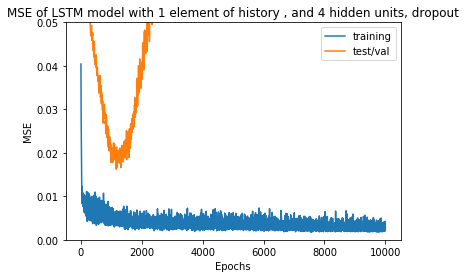

In [29]:
plt.plot(range(1,10001),output.history['loss'],label='training')
plt.plot(range(1,10001),output.history['val_loss'],label='test/val')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.ylim(0,0.05)
plt.title('MSE of LSTM model with 1 element of history , and 4 hidden units, dropout')

Oops... We have worsen the situation: Bias is increased as well as variance, and we see now overfitting after 1000 epochs...

In [32]:
rmse_train, train_predict = predict_and_score(model, scaler,train_X, train_Y)
rmse_test, test_predict = predict_and_score(model, scaler,test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 25.34 RMSE
Test data score: 160.26 RMSE


Train on 85 samples, validate on 57 samples
Epoch 1/1000
85/85 [==============================] - 1s 16ms/sample - loss: 0.0597 - val_loss: 0.4442
Epoch 2/1000
85/85 [==============================] - 0s 82us/sample - loss: 0.0572 - val_loss: 0.4348
Epoch 3/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0548 - val_loss: 0.4254
Epoch 4/1000
85/85 [==============================] - 0s 176us/sample - loss: 0.0526 - val_loss: 0.4163
Epoch 5/1000
85/85 [==============================] - 0s 176us/sample - loss: 0.0503 - val_loss: 0.4074
Epoch 6/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0482 - val_loss: 0.3988
Epoch 7/1000
85/85 [==============================] - 0s 165us/sample - loss: 0.0462 - val_loss: 0.3903
Epoch 8/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0442 - val_loss: 0.3820
Epoch 9/1000
85/85 [==============================] - 0s 176us/sample - loss: 0.0424 - val_loss: 0.3739
Epoch 10/1000
85/85 [=

85/85 [==============================] - 0s 153us/sample - loss: 0.0116 - val_loss: 0.1574
Epoch 79/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0116 - val_loss: 0.1566
Epoch 80/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0115 - val_loss: 0.1559
Epoch 81/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0115 - val_loss: 0.1552
Epoch 82/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0115 - val_loss: 0.1546
Epoch 83/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0114 - val_loss: 0.1541
Epoch 84/1000
85/85 [==============================] - 0s 164us/sample - loss: 0.0114 - val_loss: 0.1534
Epoch 85/1000
85/85 [==============================] - 0s 176us/sample - loss: 0.0114 - val_loss: 0.1528
Epoch 86/1000
85/85 [==============================] - 0s 164us/sample - loss: 0.0113 - val_loss: 0.1522
Epoch 87/1000
85/85 [==============================] - 0s 141us/sampl

85/85 [==============================] - 0s 94us/sample - loss: 0.0088 - val_loss: 0.1136
Epoch 156/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0087 - val_loss: 0.1130
Epoch 157/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0087 - val_loss: 0.1125
Epoch 158/1000
85/85 [==============================] - 0s 141us/sample - loss: 0.0087 - val_loss: 0.1120
Epoch 159/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0086 - val_loss: 0.1115
Epoch 160/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0086 - val_loss: 0.1110
Epoch 161/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0085 - val_loss: 0.1107
Epoch 162/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0085 - val_loss: 0.1102
Epoch 163/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0085 - val_loss: 0.1097
Epoch 164/1000
85/85 [==============================] - 0s 106

Epoch 233/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0057 - val_loss: 0.0682
Epoch 234/1000
85/85 [==============================] - 0s 82us/sample - loss: 0.0056 - val_loss: 0.0676
Epoch 235/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0056 - val_loss: 0.0669
Epoch 236/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0055 - val_loss: 0.0664
Epoch 237/1000
85/85 [==============================] - 0s 164us/sample - loss: 0.0055 - val_loss: 0.0659
Epoch 238/1000
85/85 [==============================] - 0s 164us/sample - loss: 0.0055 - val_loss: 0.0653
Epoch 239/1000
85/85 [==============================] - 0s 164us/sample - loss: 0.0054 - val_loss: 0.0647
Epoch 240/1000
85/85 [==============================] - 0s 164us/sample - loss: 0.0054 - val_loss: 0.0642
Epoch 241/1000
85/85 [==============================] - 0s 141us/sample - loss: 0.0053 - val_loss: 0.0636
Epoch 242/1000
85/85 [=========================

85/85 [==============================] - 0s 94us/sample - loss: 0.0030 - val_loss: 0.0304
Epoch 311/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0030 - val_loss: 0.0300
Epoch 312/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0029 - val_loss: 0.0296
Epoch 313/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0029 - val_loss: 0.0293
Epoch 314/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0029 - val_loss: 0.0289
Epoch 315/1000
85/85 [==============================] - 0s 164us/sample - loss: 0.0029 - val_loss: 0.0285
Epoch 316/1000
85/85 [==============================] - 0s 141us/sample - loss: 0.0028 - val_loss: 0.0281
Epoch 317/1000
85/85 [==============================] - 0s 141us/sample - loss: 0.0028 - val_loss: 0.0277
Epoch 318/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0028 - val_loss: 0.0273
Epoch 319/1000
85/85 [==============================] - 0s 117

85/85 [==============================] - 0s 94us/sample - loss: 0.0018 - val_loss: 0.0125
Epoch 388/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0018 - val_loss: 0.0124
Epoch 389/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0018 - val_loss: 0.0123
Epoch 390/1000
85/85 [==============================] - 0s 94us/sample - loss: 0.0018 - val_loss: 0.0122
Epoch 391/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0018 - val_loss: 0.0121
Epoch 392/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0018 - val_loss: 0.0120
Epoch 393/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0018 - val_loss: 0.0119
Epoch 394/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0018 - val_loss: 0.0118
Epoch 395/1000
85/85 [==============================] - 0s 141us/sample - loss: 0.0018 - val_loss: 0.0117
Epoch 396/1000
85/85 [==============================] - 0s 129u

85/85 [==============================] - 0s 94us/sample - loss: 0.0016 - val_loss: 0.0087
Epoch 465/1000
85/85 [==============================] - 0s 94us/sample - loss: 0.0016 - val_loss: 0.0087
Epoch 466/1000
85/85 [==============================] - 0s 141us/sample - loss: 0.0016 - val_loss: 0.0087
Epoch 467/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0016 - val_loss: 0.0087
Epoch 468/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0016 - val_loss: 0.0087
Epoch 469/1000
85/85 [==============================] - 0s 211us/sample - loss: 0.0016 - val_loss: 0.0086
Epoch 470/1000
85/85 [==============================] - 0s 141us/sample - loss: 0.0016 - val_loss: 0.0087
Epoch 471/1000
85/85 [==============================] - 0s 176us/sample - loss: 0.0016 - val_loss: 0.0087
Epoch 472/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0016 - val_loss: 0.0086
Epoch 473/1000
85/85 [==============================] - 0s 117u

85/85 [==============================] - 0s 117us/sample - loss: 0.0016 - val_loss: 0.0082
Epoch 542/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0016 - val_loss: 0.0082
Epoch 543/1000
85/85 [==============================] - 0s 82us/sample - loss: 0.0016 - val_loss: 0.0082
Epoch 544/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0081
Epoch 545/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0016 - val_loss: 0.0081
Epoch 546/1000
85/85 [==============================] - 0s 176us/sample - loss: 0.0016 - val_loss: 0.0082
Epoch 547/1000
85/85 [==============================] - 0s 164us/sample - loss: 0.0016 - val_loss: 0.0082
Epoch 548/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0016 - val_loss: 0.0082
Epoch 549/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0016 - val_loss: 0.0082
Epoch 550/1000
85/85 [==============================] - 0s 153

85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0082
Epoch 619/1000
85/85 [==============================] - 0s 94us/sample - loss: 0.0016 - val_loss: 0.0082
Epoch 620/1000
85/85 [==============================] - 0s 82us/sample - loss: 0.0016 - val_loss: 0.0082
Epoch 621/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0016 - val_loss: 0.0082
Epoch 622/1000
85/85 [==============================] - 0s 70us/sample - loss: 0.0016 - val_loss: 0.0082
Epoch 623/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0016 - val_loss: 0.0082
Epoch 624/1000
85/85 [==============================] - 0s 164us/sample - loss: 0.0016 - val_loss: 0.0082
Epoch 625/1000
85/85 [==============================] - 0s 129us/sample - loss: 0.0016 - val_loss: 0.0082
Epoch 626/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0016 - val_loss: 0.0082
Epoch 627/1000
85/85 [==============================] - 0s 129us

85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0083
Epoch 696/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0083
Epoch 697/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0083
Epoch 698/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0083
Epoch 699/1000
85/85 [==============================] - 0s 176us/sample - loss: 0.0016 - val_loss: 0.0083
Epoch 700/1000
85/85 [==============================] - 0s 164us/sample - loss: 0.0016 - val_loss: 0.0084
Epoch 701/1000
85/85 [==============================] - 0s 141us/sample - loss: 0.0016 - val_loss: 0.0084
Epoch 702/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0016 - val_loss: 0.0083
Epoch 703/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0016 - val_loss: 0.0083
Epoch 704/1000
85/85 [==============================] - 0s 11

85/85 [==============================] - 0s 117us/sample - loss: 0.0016 - val_loss: 0.0085
Epoch 773/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0016 - val_loss: 0.0084
Epoch 774/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0084
Epoch 775/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0016 - val_loss: 0.0085
Epoch 776/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0016 - val_loss: 0.0085
Epoch 777/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0016 - val_loss: 0.0085
Epoch 778/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0016 - val_loss: 0.0085
Epoch 779/1000
85/85 [==============================] - 0s 176us/sample - loss: 0.0016 - val_loss: 0.0085
Epoch 780/1000
85/85 [==============================] - 0s 164us/sample - loss: 0.0016 - val_loss: 0.0085
Epoch 781/1000
85/85 [==============================] - 0s 18

85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0086
Epoch 850/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0086
Epoch 851/1000
85/85 [==============================] - 0s 94us/sample - loss: 0.0016 - val_loss: 0.0085
Epoch 852/1000
85/85 [==============================] - 0s 117us/sample - loss: 0.0016 - val_loss: 0.0085
Epoch 853/1000
85/85 [==============================] - 0s 141us/sample - loss: 0.0016 - val_loss: 0.0085
Epoch 854/1000
85/85 [==============================] - 0s 152us/sample - loss: 0.0016 - val_loss: 0.0085
Epoch 855/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0016 - val_loss: 0.0085
Epoch 856/1000
85/85 [==============================] - 0s 200us/sample - loss: 0.0016 - val_loss: 0.0085
Epoch 857/1000
85/85 [==============================] - 0s 164us/sample - loss: 0.0016 - val_loss: 0.0086
Epoch 858/1000
85/85 [==============================] - ETA: 0

85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0089
Epoch 927/1000
85/85 [==============================] - 0s 106us/sample - loss: 0.0016 - val_loss: 0.0089
Epoch 928/1000
85/85 [==============================] - 0s 82us/sample - loss: 0.0016 - val_loss: 0.0088
Epoch 929/1000
85/85 [==============================] - 0s 94us/sample - loss: 0.0016 - val_loss: 0.0088
Epoch 930/1000
85/85 [==============================] - 0s 94us/sample - loss: 0.0016 - val_loss: 0.0088
Epoch 931/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0016 - val_loss: 0.0088
Epoch 932/1000
85/85 [==============================] - 0s 164us/sample - loss: 0.0016 - val_loss: 0.0088
Epoch 933/1000
85/85 [==============================] - 0s 153us/sample - loss: 0.0016 - val_loss: 0.0088
Epoch 934/1000
85/85 [==============================] - 0s 141us/sample - loss: 0.0016 - val_loss: 0.0088
Epoch 935/1000
85/85 [==============================] - 0s 129us

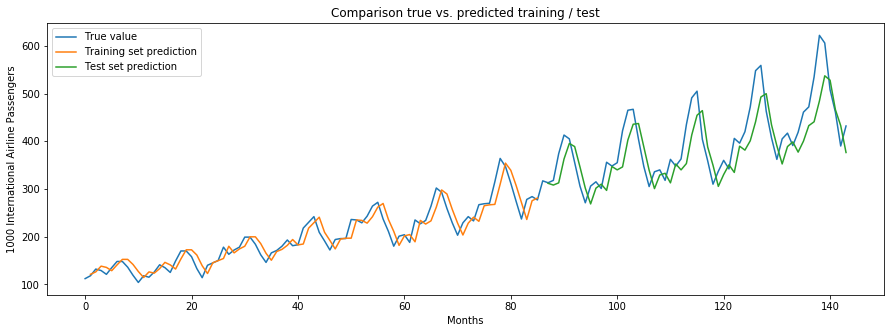

In [36]:
# So let's come back to the first model
model = Sequential()
model.add((LSTM(4, input_shape = (1, window_size))))
model.add(Dense(1))
model.compile(loss = "mean_squared_error", optimizer = "adam")
output = model.fit(train_X, train_Y, epochs = 1000,validation_data = (test_X,test_Y))

# Do the predictions
rmse_train, train_predict = predict_and_score(model, scaler,train_X, train_Y)
rmse_test, test_predict = predict_and_score(model, scaler,test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[train.shape[0] + window_size: , :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(range(144),scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

It looks like in general, we did quite a nice job! However, It looks like the curves are shifted by an amount! Probably an error in one of these functions that we have not checked :(. Well... believe it or not, there are no errors in the code. The curve is littelrally shifted. by 1 time step (actually, the code learns this behaviour from the data as we will show next. First, let us think about the model we have used....
The LSTM is fed with only 1 sample. ... Then our problem falls into the category of one to one... So the recurrence is not used by the LSTM... FInally, we have just implemented a regression model x_t = f(x_t-1). It is not necessarily linear (due to the non linear activation). But it could be interesting to see how a simple linear regression model applies...

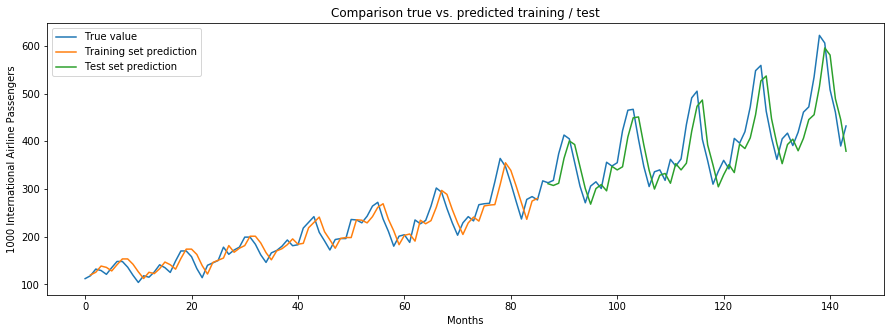

In [48]:
lm = LinearRegression()
lm.fit(train_X.reshape(-1,1),train_Y)
ytrpred = lm.predict(train_X.reshape(-1,1))
ytepred = lm.predict(test_X.reshape(-1,1))

# rescale the predictions
ytrpred = scaler.inverse_transform(ytrpred.reshape(-1,1))
ytepred = scaler.inverse_transform(ytepred.reshape(-1,1))

# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = ytrpred

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[train.shape[0] + window_size: , :] = ytepred


# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(range(144),scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

Wow!!! We have the same kind of prediction! Let's examine the prediction vs expected plot

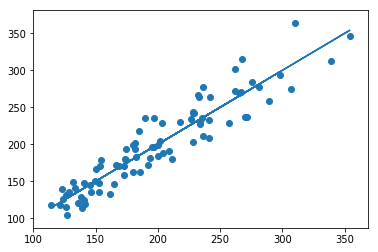

In [49]:
plt.plot(train_predict,train_predict)
plt.scatter(train_predict,scaler.inverse_transform(train_Y.reshape(-1,1)))

So we see that the model is able to learn a kind of linear model (if low number at t, low at t+1), and conversely, hence the shift... Note also that the prediction variance tends to increase with the prediction. This is called heteroscedasticity, and probably requires special treatment (from a linear model stand point...). Any way, can we get better?

To get better, we have 
- to understand the problem and the data
- to understand what LSTM does (more or less)

As stated before, there is some seasonality in the data, so... maybe it is a good idea to use a full period (or two) to predict the following month, instead of just one time step look ahead...

In [77]:
# Create test and training sets for one-step-ahead regression.
window_size = 12
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

# The model

model = Sequential()
model.add((LSTM(4, input_shape = (1, window_size))))
model.add(Dense(1))
model.compile(loss = "mean_squared_error", optimizer = "adam")
output = model.fit(train_X, train_Y, epochs = 1000,validation_data = (test_X,test_Y))

Original training data shape:
(74, 12)
New training data shape:
(74, 1, 12)
Train on 74 samples, validate on 46 samples
Epoch 1/1000
74/74 [==============================] - 2s 30ms/sample - loss: 0.0500 - val_loss: 0.3504
Epoch 2/1000
74/74 [==============================] - 0s 251us/sample - loss: 0.0473 - val_loss: 0.3375
Epoch 3/1000
74/74 [==============================] - 0s 148us/sample - loss: 0.0449 - val_loss: 0.3249
Epoch 4/1000
74/74 [==============================] - 0s 216us/sample - loss: 0.0425 - val_loss: 0.3126
Epoch 5/1000
74/74 [==============================] - 0s 175us/sample - loss: 0.0402 - val_loss: 0.3008
Epoch 6/1000
74/74 [==============================] - 0s 162us/sample - loss: 0.0380 - val_loss: 0.2894
Epoch 7/1000
74/74 [==============================] - 0s 148us/sample - loss: 0.0358 - val_loss: 0.2783
Epoch 8/1000
74/74 [==============================] - 0s 175us/sample - loss: 0.0339 - val_loss: 0.2673
Epoch 9/1000
74/74 [=============================

74/74 [==============================] - 0s 121us/sample - loss: 0.0043 - val_loss: 0.0315
Epoch 79/1000
74/74 [==============================] - 0s 135us/sample - loss: 0.0043 - val_loss: 0.0312
Epoch 80/1000
74/74 [==============================] - 0s 135us/sample - loss: 0.0043 - val_loss: 0.0307
Epoch 81/1000
74/74 [==============================] - 0s 148us/sample - loss: 0.0042 - val_loss: 0.0302
Epoch 82/1000
74/74 [==============================] - 0s 189us/sample - loss: 0.0042 - val_loss: 0.0298
Epoch 83/1000
74/74 [==============================] - 0s 135us/sample - loss: 0.0042 - val_loss: 0.0294
Epoch 84/1000
74/74 [==============================] - 0s 162us/sample - loss: 0.0042 - val_loss: 0.0291
Epoch 85/1000
74/74 [==============================] - 0s 121us/sample - loss: 0.0042 - val_loss: 0.0288
Epoch 86/1000
74/74 [==============================] - 0s 175us/sample - loss: 0.0041 - val_loss: 0.0286
Epoch 87/1000
74/74 [==============================] - 0s 202us/sampl

74/74 [==============================] - 0s 175us/sample - loss: 0.0022 - val_loss: 0.0110
Epoch 156/1000
74/74 [==============================] - 0s 175us/sample - loss: 0.0022 - val_loss: 0.0109
Epoch 157/1000
74/74 [==============================] - 0s 135us/sample - loss: 0.0021 - val_loss: 0.0108
Epoch 158/1000
74/74 [==============================] - 0s 148us/sample - loss: 0.0021 - val_loss: 0.0107
Epoch 159/1000
74/74 [==============================] - 0s 148us/sample - loss: 0.0021 - val_loss: 0.0105
Epoch 160/1000
74/74 [==============================] - 0s 135us/sample - loss: 0.0020 - val_loss: 0.0103
Epoch 161/1000
74/74 [==============================] - 0s 121us/sample - loss: 0.0020 - val_loss: 0.0101
Epoch 162/1000
74/74 [==============================] - 0s 148us/sample - loss: 0.0020 - val_loss: 0.0099
Epoch 163/1000
74/74 [==============================] - 0s 121us/sample - loss: 0.0020 - val_loss: 0.0099
Epoch 164/1000
74/74 [==============================] - 0s 14

74/74 [==============================] - 0s 121us/sample - loss: 8.7597e-04 - val_loss: 0.0054
Epoch 232/1000
74/74 [==============================] - 0s 148us/sample - loss: 8.6793e-04 - val_loss: 0.0057
Epoch 233/1000
74/74 [==============================] - 0s 162us/sample - loss: 8.5361e-04 - val_loss: 0.0060
Epoch 234/1000
74/74 [==============================] - 0s 148us/sample - loss: 8.5076e-04 - val_loss: 0.0064
Epoch 235/1000
74/74 [==============================] - 0s 175us/sample - loss: 8.5514e-04 - val_loss: 0.0066
Epoch 236/1000
74/74 [==============================] - 0s 175us/sample - loss: 8.5252e-04 - val_loss: 0.0066
Epoch 237/1000
74/74 [==============================] - 0s 202us/sample - loss: 8.5003e-04 - val_loss: 0.0062
Epoch 238/1000
74/74 [==============================] - 0s 162us/sample - loss: 8.4087e-04 - val_loss: 0.0059
Epoch 239/1000
74/74 [==============================] - 0s 215us/sample - loss: 8.3871e-04 - val_loss: 0.0057
Epoch 240/1000
74/74 [===

74/74 [==============================] - 0s 148us/sample - loss: 7.5599e-04 - val_loss: 0.0054
Epoch 306/1000
74/74 [==============================] - 0s 121us/sample - loss: 7.5321e-04 - val_loss: 0.0053
Epoch 307/1000
74/74 [==============================] - 0s 121us/sample - loss: 7.5175e-04 - val_loss: 0.0053
Epoch 308/1000
74/74 [==============================] - 0s 108us/sample - loss: 7.5218e-04 - val_loss: 0.0052
Epoch 309/1000
74/74 [==============================] - 0s 216us/sample - loss: 7.5130e-04 - val_loss: 0.0050
Epoch 310/1000
74/74 [==============================] - 0s 216us/sample - loss: 7.5227e-04 - val_loss: 0.0050
Epoch 311/1000
74/74 [==============================] - 0s 148us/sample - loss: 7.5294e-04 - val_loss: 0.0049
Epoch 312/1000
74/74 [==============================] - 0s 188us/sample - loss: 7.5207e-04 - val_loss: 0.0049
Epoch 313/1000
74/74 [==============================] - 0s 162us/sample - loss: 7.5053e-04 - val_loss: 0.0051
Epoch 314/1000
74/74 [===

74/74 [==============================] - 0s 135us/sample - loss: 7.0215e-04 - val_loss: 0.0055
Epoch 380/1000
74/74 [==============================] - 0s 121us/sample - loss: 7.0034e-04 - val_loss: 0.0054
Epoch 381/1000
74/74 [==============================] - 0s 135us/sample - loss: 7.0012e-04 - val_loss: 0.0053
Epoch 382/1000
74/74 [==============================] - 0s 121us/sample - loss: 6.9922e-04 - val_loss: 0.0052
Epoch 383/1000
74/74 [==============================] - 0s 148us/sample - loss: 6.9942e-04 - val_loss: 0.0052
Epoch 384/1000
74/74 [==============================] - 0s 175us/sample - loss: 6.9815e-04 - val_loss: 0.0054
Epoch 385/1000
74/74 [==============================] - 0s 189us/sample - loss: 6.9884e-04 - val_loss: 0.0054
Epoch 386/1000
74/74 [==============================] - 0s 189us/sample - loss: 6.9770e-04 - val_loss: 0.0053
Epoch 387/1000
74/74 [==============================] - 0s 189us/sample - loss: 6.9794e-04 - val_loss: 0.0052
Epoch 388/1000
74/74 [===

74/74 [==============================] - 0s 121us/sample - loss: 6.6453e-04 - val_loss: 0.0050
Epoch 454/1000
74/74 [==============================] - 0s 135us/sample - loss: 6.6108e-04 - val_loss: 0.0052
Epoch 455/1000
74/74 [==============================] - 0s 135us/sample - loss: 6.6135e-04 - val_loss: 0.0054
Epoch 456/1000
74/74 [==============================] - 0s 121us/sample - loss: 6.6456e-04 - val_loss: 0.0055
Epoch 457/1000
74/74 [==============================] - 0s 175us/sample - loss: 6.6641e-04 - val_loss: 0.0056
Epoch 458/1000
74/74 [==============================] - 0s 216us/sample - loss: 6.6627e-04 - val_loss: 0.0054
Epoch 459/1000
74/74 [==============================] - 0s 202us/sample - loss: 6.6777e-04 - val_loss: 0.0051
Epoch 460/1000
74/74 [==============================] - 0s 162us/sample - loss: 6.5969e-04 - val_loss: 0.0051
Epoch 461/1000
74/74 [==============================] - 0s 162us/sample - loss: 6.5831e-04 - val_loss: 0.0050
Epoch 462/1000
74/74 [===

74/74 [==============================] - 0s 121us/sample - loss: 6.4137e-04 - val_loss: 0.0046
Epoch 528/1000
74/74 [==============================] - 0s 135us/sample - loss: 6.4038e-04 - val_loss: 0.0049
Epoch 529/1000
74/74 [==============================] - 0s 94us/sample - loss: 6.3452e-04 - val_loss: 0.0051
Epoch 530/1000
74/74 [==============================] - 0s 148us/sample - loss: 6.3123e-04 - val_loss: 0.0054
Epoch 531/1000
74/74 [==============================] - 0s 135us/sample - loss: 6.4106e-04 - val_loss: 0.0057
Epoch 532/1000
74/74 [==============================] - 0s 162us/sample - loss: 6.3879e-04 - val_loss: 0.0056
Epoch 533/1000
74/74 [==============================] - 0s 148us/sample - loss: 6.3566e-04 - val_loss: 0.0054
Epoch 534/1000
74/74 [==============================] - 0s 175us/sample - loss: 6.3407e-04 - val_loss: 0.0051
Epoch 535/1000
74/74 [==============================] - 0s 162us/sample - loss: 6.3052e-04 - val_loss: 0.0049
Epoch 536/1000
74/74 [====

74/74 [==============================] - 0s 94us/sample - loss: 6.1104e-04 - val_loss: 0.0045
Epoch 602/1000
74/74 [==============================] - 0s 121us/sample - loss: 6.0501e-04 - val_loss: 0.0048
Epoch 603/1000
74/74 [==============================] - 0s 148us/sample - loss: 6.0716e-04 - val_loss: 0.0049
Epoch 604/1000
74/74 [==============================] - 0s 108us/sample - loss: 6.0945e-04 - val_loss: 0.0048
Epoch 605/1000
74/74 [==============================] - 0s 148us/sample - loss: 6.0889e-04 - val_loss: 0.0044
Epoch 606/1000
74/74 [==============================] - 0s 202us/sample - loss: 6.0378e-04 - val_loss: 0.0043
Epoch 607/1000
74/74 [==============================] - 0s 175us/sample - loss: 6.0439e-04 - val_loss: 0.0042
Epoch 608/1000
74/74 [==============================] - 0s 175us/sample - loss: 6.0671e-04 - val_loss: 0.0041
Epoch 609/1000
74/74 [==============================] - 0s 148us/sample - loss: 6.0654e-04 - val_loss: 0.0043
Epoch 610/1000
74/74 [====

74/74 [==============================] - 0s 162us/sample - loss: 5.8532e-04 - val_loss: 0.0043
Epoch 676/1000
74/74 [==============================] - 0s 135us/sample - loss: 5.8475e-04 - val_loss: 0.0042
Epoch 677/1000
74/74 [==============================] - 0s 189us/sample - loss: 5.8730e-04 - val_loss: 0.0041
Epoch 678/1000
74/74 [==============================] - 0s 108us/sample - loss: 5.8607e-04 - val_loss: 0.0043
Epoch 679/1000
74/74 [==============================] - 0s 135us/sample - loss: 5.8478e-04 - val_loss: 0.0045
Epoch 680/1000
74/74 [==============================] - 0s 228us/sample - loss: 5.9017e-04 - val_loss: 0.0047
Epoch 681/1000
74/74 [==============================] - 0s 202us/sample - loss: 5.8597e-04 - val_loss: 0.0045
Epoch 682/1000
74/74 [==============================] - 0s 216us/sample - loss: 5.8160e-04 - val_loss: 0.0042
Epoch 683/1000
74/74 [==============================] - 0s 202us/sample - loss: 5.8825e-04 - val_loss: 0.0039
Epoch 684/1000
74/74 [===

74/74 [==============================] - 0s 175us/sample - loss: 5.7097e-04 - val_loss: 0.0038
Epoch 750/1000
74/74 [==============================] - 0s 135us/sample - loss: 5.7109e-04 - val_loss: 0.0040
Epoch 751/1000
74/74 [==============================] - 0s 162us/sample - loss: 5.6930e-04 - val_loss: 0.0039
Epoch 752/1000
74/74 [==============================] - 0s 148us/sample - loss: 5.6859e-04 - val_loss: 0.0039
Epoch 753/1000
74/74 [==============================] - 0s 121us/sample - loss: 5.6690e-04 - val_loss: 0.0040
Epoch 754/1000
74/74 [==============================] - 0s 148us/sample - loss: 5.6763e-04 - val_loss: 0.0041
Epoch 755/1000
74/74 [==============================] - 0s 189us/sample - loss: 5.6816e-04 - val_loss: 0.0040
Epoch 756/1000
74/74 [==============================] - 0s 216us/sample - loss: 5.6766e-04 - val_loss: 0.0039
Epoch 757/1000
74/74 [==============================] - 0s 202us/sample - loss: 5.6885e-04 - val_loss: 0.0040
Epoch 758/1000
74/74 [===

74/74 [==============================] - 0s 148us/sample - loss: 5.5421e-04 - val_loss: 0.0048
Epoch 824/1000
74/74 [==============================] - 0s 148us/sample - loss: 5.6527e-04 - val_loss: 0.0051
Epoch 825/1000
74/74 [==============================] - 0s 121us/sample - loss: 5.7224e-04 - val_loss: 0.0048
Epoch 826/1000
74/74 [==============================] - 0s 148us/sample - loss: 5.5925e-04 - val_loss: 0.0042
Epoch 827/1000
74/74 [==============================] - 0s 216us/sample - loss: 5.5187e-04 - val_loss: 0.0037
Epoch 828/1000
74/74 [==============================] - 0s 175us/sample - loss: 5.5514e-04 - val_loss: 0.0033
Epoch 829/1000
74/74 [==============================] - 0s 175us/sample - loss: 5.6432e-04 - val_loss: 0.0033
Epoch 830/1000
74/74 [==============================] - 0s 243us/sample - loss: 5.6198e-04 - val_loss: 0.0036
Epoch 831/1000
74/74 [==============================] - 0s 216us/sample - loss: 5.5376e-04 - val_loss: 0.0040
Epoch 832/1000
74/74 [===

74/74 [==============================] - 0s 135us/sample - loss: 5.3784e-04 - val_loss: 0.0038
Epoch 898/1000
74/74 [==============================] - 0s 108us/sample - loss: 5.3954e-04 - val_loss: 0.0039
Epoch 899/1000
74/74 [==============================] - 0s 121us/sample - loss: 5.3635e-04 - val_loss: 0.0039
Epoch 900/1000
74/74 [==============================] - 0s 189us/sample - loss: 5.3633e-04 - val_loss: 0.0037
Epoch 901/1000
74/74 [==============================] - 0s 256us/sample - loss: 5.3483e-04 - val_loss: 0.0037
Epoch 902/1000
74/74 [==============================] - 0s 202us/sample - loss: 5.3465e-04 - val_loss: 0.0037
Epoch 903/1000
74/74 [==============================] - 0s 202us/sample - loss: 5.3510e-04 - val_loss: 0.0038
Epoch 904/1000
74/74 [==============================] - 0s 189us/sample - loss: 5.3634e-04 - val_loss: 0.0039
Epoch 905/1000
74/74 [==============================] - 0s 162us/sample - loss: 5.3623e-04 - val_loss: 0.0037
Epoch 906/1000
74/74 [===

74/74 [==============================] - 0s 121us/sample - loss: 5.2357e-04 - val_loss: 0.0031
Epoch 972/1000
74/74 [==============================] - 0s 108us/sample - loss: 5.2553e-04 - val_loss: 0.0031
Epoch 973/1000
74/74 [==============================] - 0s 135us/sample - loss: 5.2463e-04 - val_loss: 0.0033
Epoch 974/1000
74/74 [==============================] - 0s 175us/sample - loss: 5.2314e-04 - val_loss: 0.0035
Epoch 975/1000
74/74 [==============================] - 0s 256us/sample - loss: 5.2003e-04 - val_loss: 0.0034
Epoch 976/1000
74/74 [==============================] - 0s 202us/sample - loss: 5.1940e-04 - val_loss: 0.0035
Epoch 977/1000
74/74 [==============================] - 0s 202us/sample - loss: 5.1930e-04 - val_loss: 0.0033
Epoch 978/1000
74/74 [==============================] - 0s 189us/sample - loss: 5.1884e-04 - val_loss: 0.0033
Epoch 979/1000
74/74 [==============================] - 0s 162us/sample - loss: 5.1937e-04 - val_loss: 0.0033
Epoch 980/1000
74/74 [===

Text(0.5, 1.0, 'MSE of LSTM model with 24 elements of history , and 4 hidden units')

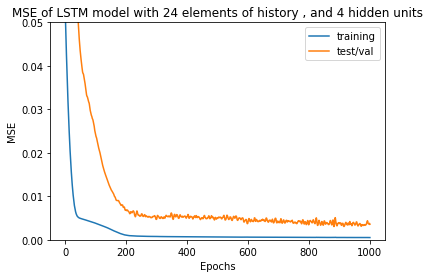

In [78]:
plt.plot(range(1,1001),output.history['loss'],label='training')
plt.plot(range(1,1001),output.history['val_loss'],label='test/val')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.ylim(0,0.05)
plt.title('MSE of LSTM model with 24 elements of history , and 4 hidden units')

Training data score: 11.74 RMSE
Test data score: 30.93 RMSE


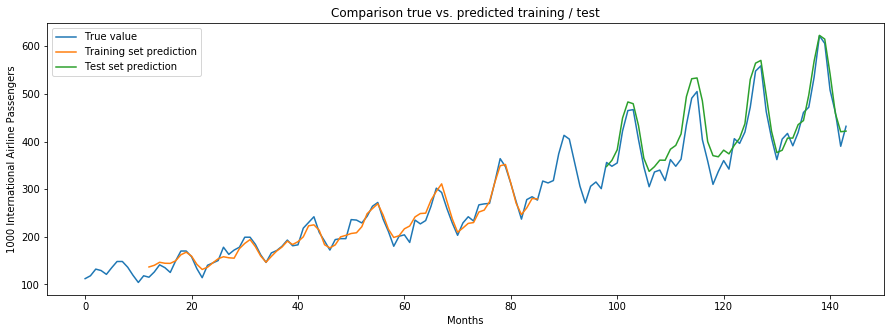

In [79]:
# Do the predictions
rmse_train, train_predict = predict_and_score(model, scaler,train_X, train_Y)
rmse_test, test_predict = predict_and_score(model, scaler,test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[train.shape[0] + window_size: , :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(range(144),scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

Now we have a low bias, but variance is probably still a bit high !!! We will see later that we could solve completely the problem by increasing the window size... But first, let's try to decrease the bias

In [84]:
# The model

model = Sequential()
model.add((LSTM(512, input_shape = (1, window_size),dropout=0)))
model.add(Dense(1))
model.compile(loss = "mean_squared_error", optimizer = "adam")
output = model.fit(train_X, train_Y, epochs = 1000,validation_data = (test_X,test_Y))

Train on 74 samples, validate on 46 samples
Epoch 1/1000
74/74 [==============================] - 3s 38ms/sample - loss: 0.0477 - val_loss: 0.2034
Epoch 2/1000
74/74 [==============================] - 0s 1ms/sample - loss: 0.0208 - val_loss: 0.0767
Epoch 3/1000
74/74 [==============================] - 0s 1ms/sample - loss: 0.0058 - val_loss: 0.0214
Epoch 4/1000
74/74 [==============================] - 0s 1ms/sample - loss: 0.0038 - val_loss: 0.0194
Epoch 5/1000
74/74 [==============================] - 0s 1ms/sample - loss: 0.0070 - val_loss: 0.0276
Epoch 6/1000
74/74 [==============================] - 0s 1ms/sample - loss: 0.0088 - val_loss: 0.0235
Epoch 7/1000
74/74 [==============================] - 0s 1ms/sample - loss: 0.0069 - val_loss: 0.0159
Epoch 8/1000
74/74 [==============================] - 0s 1ms/sample - loss: 0.0043 - val_loss: 0.0163
Epoch 9/1000
74/74 [==============================] - 0s 1ms/sample - loss: 0.0031 - val_loss: 0.0234
Epoch 10/1000
74/74 [================

74/74 [==============================] - 0s 2ms/sample - loss: 6.7648e-04 - val_loss: 0.0034
Epoch 80/1000
74/74 [==============================] - 0s 1ms/sample - loss: 6.8928e-04 - val_loss: 0.0030
Epoch 81/1000
74/74 [==============================] - 0s 1ms/sample - loss: 6.8430e-04 - val_loss: 0.0039
Epoch 82/1000
74/74 [==============================] - 0s 1ms/sample - loss: 7.1555e-04 - val_loss: 0.0059
Epoch 83/1000
74/74 [==============================] - 0s 1ms/sample - loss: 6.9912e-04 - val_loss: 0.0047
Epoch 84/1000
74/74 [==============================] - 0s 1ms/sample - loss: 6.4739e-04 - val_loss: 0.0031
Epoch 85/1000
74/74 [==============================] - 0s 1ms/sample - loss: 6.9783e-04 - val_loss: 0.0028
Epoch 86/1000
74/74 [==============================] - 0s 1ms/sample - loss: 6.9224e-04 - val_loss: 0.0040
Epoch 87/1000
74/74 [==============================] - 0s 1ms/sample - loss: 6.3852e-04 - val_loss: 0.0054
Epoch 88/1000
74/74 [==============================

74/74 [==============================] - 0s 1ms/sample - loss: 5.1685e-04 - val_loss: 0.0026
Epoch 156/1000
74/74 [==============================] - 0s 1ms/sample - loss: 6.0726e-04 - val_loss: 0.0031
Epoch 157/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.7538e-04 - val_loss: 0.0057
Epoch 158/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.4235e-04 - val_loss: 0.0052
Epoch 159/1000
74/74 [==============================] - ETA: 0s - loss: 6.2508e-0 - 0s 1ms/sample - loss: 5.3280e-04 - val_loss: 0.0046
Epoch 160/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.2926e-04 - val_loss: 0.0047
Epoch 161/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.3359e-04 - val_loss: 0.0044
Epoch 162/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.5718e-04 - val_loss: 0.0040
Epoch 163/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.2229e-04 - val_loss: 0.0057
Epoch 164/1000


74/74 [==============================] - 0s 1ms/sample - loss: 5.0062e-04 - val_loss: 0.0036
Epoch 231/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.1101e-04 - val_loss: 0.0041
Epoch 232/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.9661e-04 - val_loss: 0.0045
Epoch 233/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.9818e-04 - val_loss: 0.0054
Epoch 234/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.2268e-04 - val_loss: 0.0058
Epoch 235/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.2898e-04 - val_loss: 0.0046
Epoch 236/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.8557e-04 - val_loss: 0.0067
Epoch 237/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.1847e-04 - val_loss: 0.0061
Epoch 238/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.1462e-04 - val_loss: 0.0038
Epoch 239/1000
74/74 [=====================

Epoch 306/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.2580e-04 - val_loss: 0.0040
Epoch 307/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.9153e-04 - val_loss: 0.0072
Epoch 308/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.0626e-04 - val_loss: 0.0058
Epoch 309/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.9711e-04 - val_loss: 0.0046
Epoch 310/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.8177e-04 - val_loss: 0.0056
Epoch 311/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7967e-04 - val_loss: 0.0055
Epoch 312/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7717e-04 - val_loss: 0.0052
Epoch 313/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7800e-04 - val_loss: 0.0055
Epoch 314/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7428e-04 - val_loss: 0.0066
Epoch 315/1000
74/74 [======

Epoch 382/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.8657e-04 - val_loss: 0.0071
Epoch 383/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.6436e-04 - val_loss: 0.0047
Epoch 384/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.2123e-04 - val_loss: 0.0057
Epoch 385/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7223e-04 - val_loss: 0.0092
Epoch 386/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.9276e-04 - val_loss: 0.0063
Epoch 387/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7387e-04 - val_loss: 0.0041
Epoch 388/1000
74/74 [==============================] - 0s 2ms/sample - loss: 5.5481e-04 - val_loss: 0.0070
Epoch 389/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.6871e-04 - val_loss: 0.0098
Epoch 390/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.9558e-04 - val_loss: 0.0073
Epoch 391/1000
74/74 [======

Epoch 458/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.6497e-04 - val_loss: 0.0056
Epoch 459/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7714e-04 - val_loss: 0.0075
Epoch 460/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.6221e-04 - val_loss: 0.0090
Epoch 461/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.9179e-04 - val_loss: 0.0083
Epoch 462/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7788e-04 - val_loss: 0.0080
Epoch 463/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.6618e-04 - val_loss: 0.0096
Epoch 464/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7672e-04 - val_loss: 0.0074
Epoch 465/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7481e-04 - val_loss: 0.0079
Epoch 466/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7983e-04 - val_loss: 0.0107
Epoch 467/1000
74/74 [======

Epoch 534/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.9311e-04 - val_loss: 0.0066
Epoch 535/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.5376e-04 - val_loss: 0.0100
Epoch 536/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.9820e-04 - val_loss: 0.0095
Epoch 537/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7079e-04 - val_loss: 0.0053
Epoch 538/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.3070e-04 - val_loss: 0.0065
Epoch 539/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.6658e-04 - val_loss: 0.0096
Epoch 540/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.0213e-04 - val_loss: 0.0090
Epoch 541/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.6035e-04 - val_loss: 0.0067
Epoch 542/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7076e-04 - val_loss: 0.0081
Epoch 543/1000
74/74 [======

Epoch 610/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.1377e-04 - val_loss: 0.0059
Epoch 611/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.0169e-04 - val_loss: 0.0133
Epoch 612/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.7145e-04 - val_loss: 0.0112
Epoch 613/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.6123e-04 - val_loss: 0.0055
Epoch 614/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.4025e-04 - val_loss: 0.0072
Epoch 615/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.4948e-04 - val_loss: 0.0121
Epoch 616/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.4890e-04 - val_loss: 0.0050
Epoch 617/1000
74/74 [==============================] - 0s 1ms/sample - loss: 6.2051e-04 - val_loss: 0.0047
Epoch 618/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.1745e-04 - val_loss: 0.0145
Epoch 619/1000
74/74 [======

Epoch 686/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7585e-04 - val_loss: 0.0087
Epoch 687/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.6511e-04 - val_loss: 0.0059
Epoch 688/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.8999e-04 - val_loss: 0.0091
Epoch 689/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7802e-04 - val_loss: 0.0104
Epoch 690/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.8741e-04 - val_loss: 0.0072
Epoch 691/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.5953e-04 - val_loss: 0.0092
Epoch 692/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.5748e-04 - val_loss: 0.0074
Epoch 693/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.6069e-04 - val_loss: 0.0066
Epoch 694/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.6729e-04 - val_loss: 0.0089
Epoch 695/1000
74/74 [======

Epoch 762/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.6111e-04 - val_loss: 0.0039
Epoch 763/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.6767e-04 - val_loss: 0.0134
Epoch 764/1000
74/74 [==============================] - 0s 1ms/sample - loss: 6.2407e-04 - val_loss: 0.0109
Epoch 765/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7966e-04 - val_loss: 0.0045
Epoch 766/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.4255e-04 - val_loss: 0.0111
Epoch 767/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.1040e-04 - val_loss: 0.0130
Epoch 768/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.0984e-04 - val_loss: 0.0071
Epoch 769/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7314e-04 - val_loss: 0.0109
Epoch 770/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7181e-04 - val_loss: 0.0116
Epoch 771/1000
74/74 [======

Epoch 838/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.6014e-04 - val_loss: 0.0102
Epoch 839/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7013e-04 - val_loss: 0.0090
Epoch 840/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7549e-04 - val_loss: 0.0090
Epoch 841/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.8814e-04 - val_loss: 0.0073
Epoch 842/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.9348e-04 - val_loss: 0.0116
Epoch 843/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.5777e-04 - val_loss: 0.0101
Epoch 844/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.5722e-04 - val_loss: 0.0109
Epoch 845/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.5776e-04 - val_loss: 0.0135
Epoch 846/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7808e-04 - val_loss: 0.0098
Epoch 847/1000
74/74 [======

Epoch 914/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7563e-04 - val_loss: 0.0086
Epoch 915/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.6312e-04 - val_loss: 0.0094
Epoch 916/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.8433e-04 - val_loss: 0.0082
Epoch 917/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.6843e-04 - val_loss: 0.0133
Epoch 918/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.9464e-04 - val_loss: 0.0096
Epoch 919/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.5968e-04 - val_loss: 0.0086
Epoch 920/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.5631e-04 - val_loss: 0.0128
Epoch 921/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7813e-04 - val_loss: 0.0125
Epoch 922/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.5309e-04 - val_loss: 0.0091
Epoch 923/1000
74/74 [======

Epoch 990/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.0782e-04 - val_loss: 0.0083
Epoch 991/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.5349e-04 - val_loss: 0.0141
Epoch 992/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.2393e-04 - val_loss: 0.0108
Epoch 993/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.5909e-04 - val_loss: 0.0076
Epoch 994/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7148e-04 - val_loss: 0.0122
Epoch 995/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.9151e-04 - val_loss: 0.0160
Epoch 996/1000
74/74 [==============================] - 0s 1ms/sample - loss: 5.2339e-04 - val_loss: 0.0086
Epoch 997/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.9945e-04 - val_loss: 0.0072
Epoch 998/1000
74/74 [==============================] - 0s 1ms/sample - loss: 4.7386e-04 - val_loss: 0.0155
Epoch 999/1000
74/74 [======

Text(0.5, 1.0, 'MSE of LSTM model with 24 elements of history , and 4 hidden units')

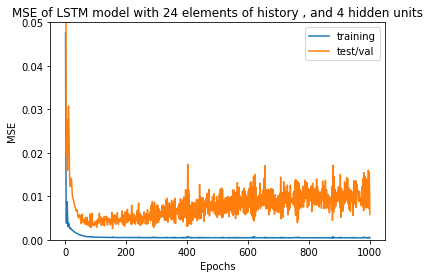

In [85]:
plt.plot(range(1,1001),output.history['loss'],label='training')
plt.plot(range(1,1001),output.history['val_loss'],label='test/val')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.ylim(0,0.05)
plt.title('MSE of LSTM model with 24 elements of history , and 4 hidden units')

Optimal model is at epoch 88... Normal decision in this situation would be to stop there. Let's ignore this and consider the final model

Training data score: 11.86 RMSE
Test data score: 39.42 RMSE


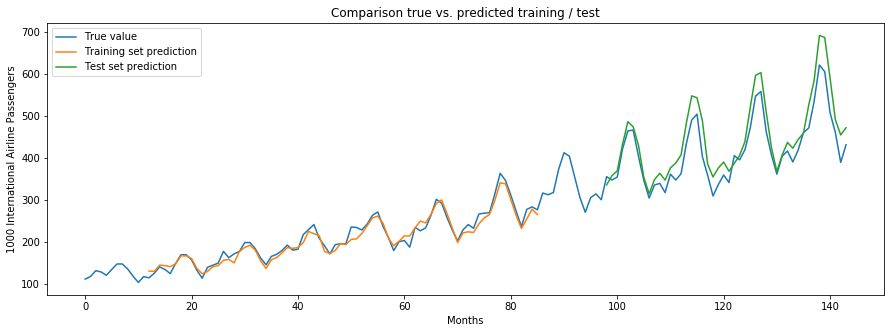

In [86]:
# Do the predictions
rmse_train, train_predict = predict_and_score(model, scaler,train_X, train_Y)
rmse_test, test_predict = predict_and_score(model, scaler,test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[train.shape[0] + window_size: , :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(range(144),scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

No, it does not work!!! We do not do any better there!!! Let us increase instead the window size to 24

In [87]:
# Create test and training sets for one-step-ahead regression.
window_size = 24
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

# The model

model = Sequential()
model.add((LSTM(4, input_shape = (1, window_size))))
model.add(Dense(1))
model.compile(loss = "mean_squared_error", optimizer = "adam")
output = model.fit(train_X, train_Y, epochs = 1000,validation_data = (test_X,test_Y))

Original training data shape:
(62, 24)
New training data shape:
(62, 1, 24)
Train on 62 samples, validate on 34 samples
Epoch 1/1000
62/62 [==============================] - 3s 47ms/sample - loss: 0.0927 - val_loss: 0.5876
Epoch 2/1000
62/62 [==============================] - 0s 97us/sample - loss: 0.0884 - val_loss: 0.5663
Epoch 3/1000
62/62 [==============================] - 0s 129us/sample - loss: 0.0841 - val_loss: 0.5459
Epoch 4/1000
62/62 [==============================] - 0s 129us/sample - loss: 0.0801 - val_loss: 0.5263
Epoch 5/1000
62/62 [==============================] - 0s 209us/sample - loss: 0.0760 - val_loss: 0.5077
Epoch 6/1000
62/62 [==============================] - 0s 161us/sample - loss: 0.0724 - val_loss: 0.4898
Epoch 7/1000
62/62 [==============================] - 0s 161us/sample - loss: 0.0688 - val_loss: 0.4726
Epoch 8/1000
62/62 [==============================] - 0s 145us/sample - loss: 0.0652 - val_loss: 0.4562
Epoch 9/1000
62/62 [==============================

62/62 [==============================] - 0s 145us/sample - loss: 0.0028 - val_loss: 0.0312
Epoch 79/1000
62/62 [==============================] - 0s 81us/sample - loss: 0.0028 - val_loss: 0.0309
Epoch 80/1000
62/62 [==============================] - 0s 161us/sample - loss: 0.0028 - val_loss: 0.0308
Epoch 81/1000
62/62 [==============================] - 0s 129us/sample - loss: 0.0028 - val_loss: 0.0305
Epoch 82/1000
62/62 [==============================] - 0s 161us/sample - loss: 0.0028 - val_loss: 0.0303
Epoch 83/1000
62/62 [==============================] - 0s 209us/sample - loss: 0.0028 - val_loss: 0.0301
Epoch 84/1000
62/62 [==============================] - 0s 145us/sample - loss: 0.0028 - val_loss: 0.0298
Epoch 85/1000
62/62 [==============================] - 0s 161us/sample - loss: 0.0028 - val_loss: 0.0295
Epoch 86/1000
62/62 [==============================] - 0s 113us/sample - loss: 0.0028 - val_loss: 0.0293
Epoch 87/1000
62/62 [==============================] - 0s 160us/sample

Epoch 156/1000
62/62 [==============================] - 0s 145us/sample - loss: 0.0022 - val_loss: 0.0140
Epoch 157/1000
62/62 [==============================] - 0s 129us/sample - loss: 0.0022 - val_loss: 0.0139
Epoch 158/1000
62/62 [==============================] - 0s 113us/sample - loss: 0.0022 - val_loss: 0.0137
Epoch 159/1000
62/62 [==============================] - 0s 145us/sample - loss: 0.0021 - val_loss: 0.0136
Epoch 160/1000
62/62 [==============================] - 0s 193us/sample - loss: 0.0021 - val_loss: 0.0134
Epoch 161/1000
62/62 [==============================] - 0s 177us/sample - loss: 0.0021 - val_loss: 0.0133
Epoch 162/1000
62/62 [==============================] - 0s 145us/sample - loss: 0.0021 - val_loss: 0.0132
Epoch 163/1000
62/62 [==============================] - 0s 129us/sample - loss: 0.0021 - val_loss: 0.0131
Epoch 164/1000
62/62 [==============================] - 0s 129us/sample - loss: 0.0021 - val_loss: 0.0129
Epoch 165/1000
62/62 [========================

62/62 [==============================] - 0s 129us/sample - loss: 0.0017 - val_loss: 0.0072
Epoch 234/1000
62/62 [==============================] - 0s 113us/sample - loss: 0.0017 - val_loss: 0.0071
Epoch 235/1000
62/62 [==============================] - 0s 97us/sample - loss: 0.0017 - val_loss: 0.0071
Epoch 236/1000
62/62 [==============================] - 0s 113us/sample - loss: 0.0017 - val_loss: 0.0071
Epoch 237/1000
62/62 [==============================] - 0s 145us/sample - loss: 0.0017 - val_loss: 0.0070
Epoch 238/1000
62/62 [==============================] - 0s 161us/sample - loss: 0.0017 - val_loss: 0.0070
Epoch 239/1000
62/62 [==============================] - 0s 161us/sample - loss: 0.0017 - val_loss: 0.0070
Epoch 240/1000
62/62 [==============================] - 0s 193us/sample - loss: 0.0017 - val_loss: 0.0069
Epoch 241/1000
62/62 [==============================] - 0s 161us/sample - loss: 0.0016 - val_loss: 0.0069
Epoch 242/1000
62/62 [==============================] - 0s 129

62/62 [==============================] - 0s 113us/sample - loss: 0.0014 - val_loss: 0.0062
Epoch 311/1000
62/62 [==============================] - 0s 113us/sample - loss: 0.0014 - val_loss: 0.0062
Epoch 312/1000
62/62 [==============================] - 0s 113us/sample - loss: 0.0014 - val_loss: 0.0062
Epoch 313/1000
62/62 [==============================] - 0s 113us/sample - loss: 0.0014 - val_loss: 0.0062
Epoch 314/1000
62/62 [==============================] - 0s 129us/sample - loss: 0.0013 - val_loss: 0.0062
Epoch 315/1000
62/62 [==============================] - 0s 145us/sample - loss: 0.0013 - val_loss: 0.0062
Epoch 316/1000
62/62 [==============================] - 0s 161us/sample - loss: 0.0013 - val_loss: 0.0062
Epoch 317/1000
62/62 [==============================] - 0s 177us/sample - loss: 0.0013 - val_loss: 0.0062
Epoch 318/1000
62/62 [==============================] - 0s 209us/sample - loss: 0.0013 - val_loss: 0.0062
Epoch 319/1000
62/62 [==============================] - 0s 97

62/62 [==============================] - 0s 161us/sample - loss: 0.0011 - val_loss: 0.0062
Epoch 388/1000
62/62 [==============================] - 0s 97us/sample - loss: 0.0011 - val_loss: 0.0062
Epoch 389/1000
62/62 [==============================] - 0s 128us/sample - loss: 0.0011 - val_loss: 0.0062
Epoch 390/1000
62/62 [==============================] - 0s 113us/sample - loss: 0.0011 - val_loss: 0.0062
Epoch 391/1000
62/62 [==============================] - 0s 97us/sample - loss: 0.0011 - val_loss: 0.0062
Epoch 392/1000
62/62 [==============================] - 0s 177us/sample - loss: 0.0011 - val_loss: 0.0062
Epoch 393/1000
62/62 [==============================] - 0s 193us/sample - loss: 0.0011 - val_loss: 0.0062
Epoch 394/1000
62/62 [==============================] - 0s 193us/sample - loss: 0.0011 - val_loss: 0.0062
Epoch 395/1000
62/62 [==============================] - 0s 161us/sample - loss: 0.0011 - val_loss: 0.0061
Epoch 396/1000
62/62 [==============================] - 0s 129u

62/62 [==============================] - 0s 113us/sample - loss: 9.1600e-04 - val_loss: 0.0056
Epoch 464/1000
62/62 [==============================] - 0s 113us/sample - loss: 9.1342e-04 - val_loss: 0.0056
Epoch 465/1000
62/62 [==============================] - 0s 145us/sample - loss: 9.1097e-04 - val_loss: 0.0056
Epoch 466/1000
62/62 [==============================] - 0s 161us/sample - loss: 9.0866e-04 - val_loss: 0.0055
Epoch 467/1000
62/62 [==============================] - 0s 161us/sample - loss: 9.0625e-04 - val_loss: 0.0055
Epoch 468/1000
62/62 [==============================] - 0s 161us/sample - loss: 9.0374e-04 - val_loss: 0.0055
Epoch 469/1000
62/62 [==============================] - 0s 145us/sample - loss: 9.0184e-04 - val_loss: 0.0054
Epoch 470/1000
62/62 [==============================] - 0s 145us/sample - loss: 8.9890e-04 - val_loss: 0.0054
Epoch 471/1000
62/62 [==============================] - 0s 161us/sample - loss: 8.9772e-04 - val_loss: 0.0054
Epoch 472/1000
62/62 [===

62/62 [==============================] - 0s 129us/sample - loss: 7.4730e-04 - val_loss: 0.0043
Epoch 538/1000
62/62 [==============================] - 0s 97us/sample - loss: 7.4509e-04 - val_loss: 0.0043
Epoch 539/1000
62/62 [==============================] - 0s 80us/sample - loss: 7.4655e-04 - val_loss: 0.0043
Epoch 540/1000
62/62 [==============================] - 0s 129us/sample - loss: 7.4068e-04 - val_loss: 0.0043
Epoch 541/1000
62/62 [==============================] - 0s 241us/sample - loss: 7.4068e-04 - val_loss: 0.0042
Epoch 542/1000
62/62 [==============================] - 0s 193us/sample - loss: 7.3716e-04 - val_loss: 0.0042
Epoch 543/1000
62/62 [==============================] - 0s 161us/sample - loss: 7.3464e-04 - val_loss: 0.0042
Epoch 544/1000
62/62 [==============================] - 0s 161us/sample - loss: 7.3272e-04 - val_loss: 0.0042
Epoch 545/1000
62/62 [==============================] - 0s 209us/sample - loss: 7.3037e-04 - val_loss: 0.0042
Epoch 546/1000
62/62 [=====

62/62 [==============================] - 0s 129us/sample - loss: 6.1083e-04 - val_loss: 0.0030
Epoch 612/1000
62/62 [==============================] - 0s 97us/sample - loss: 6.0791e-04 - val_loss: 0.0031
Epoch 613/1000
62/62 [==============================] - 0s 112us/sample - loss: 6.0594e-04 - val_loss: 0.0031
Epoch 614/1000
62/62 [==============================] - 0s 129us/sample - loss: 6.0468e-04 - val_loss: 0.0030
Epoch 615/1000
62/62 [==============================] - 0s 97us/sample - loss: 6.0282e-04 - val_loss: 0.0031
Epoch 616/1000
62/62 [==============================] - 0s 161us/sample - loss: 6.0121e-04 - val_loss: 0.0030
Epoch 617/1000
62/62 [==============================] - 0s 193us/sample - loss: 5.9971e-04 - val_loss: 0.0030
Epoch 618/1000
62/62 [==============================] - 0s 161us/sample - loss: 5.9804e-04 - val_loss: 0.0030
Epoch 619/1000
62/62 [==============================] - ETA: 0s - loss: 5.7446e-0 - 0s 161us/sample - loss: 5.9658e-04 - val_loss: 0.0030

62/62 [==============================] - 0s 113us/sample - loss: 5.1022e-04 - val_loss: 0.0023
Epoch 686/1000
62/62 [==============================] - 0s 129us/sample - loss: 5.0940e-04 - val_loss: 0.0023
Epoch 687/1000
62/62 [==============================] - 0s 129us/sample - loss: 5.0737e-04 - val_loss: 0.0024
Epoch 688/1000
62/62 [==============================] - 0s 113us/sample - loss: 5.0643e-04 - val_loss: 0.0024
Epoch 689/1000
62/62 [==============================] - 0s 161us/sample - loss: 5.0532e-04 - val_loss: 0.0024
Epoch 690/1000
62/62 [==============================] - 0s 225us/sample - loss: 5.0763e-04 - val_loss: 0.0024
Epoch 691/1000
62/62 [==============================] - 0s 161us/sample - loss: 5.0398e-04 - val_loss: 0.0024
Epoch 692/1000
62/62 [==============================] - 0s 161us/sample - loss: 5.0291e-04 - val_loss: 0.0023
Epoch 693/1000
62/62 [==============================] - 0s 161us/sample - loss: 5.0086e-04 - val_loss: 0.0023
Epoch 694/1000
62/62 [===

62/62 [==============================] - 0s 145us/sample - loss: 4.4763e-04 - val_loss: 0.0021
Epoch 760/1000
62/62 [==============================] - 0s 113us/sample - loss: 4.4456e-04 - val_loss: 0.0021
Epoch 761/1000
62/62 [==============================] - 0s 113us/sample - loss: 4.4376e-04 - val_loss: 0.0021
Epoch 762/1000
62/62 [==============================] - 0s 129us/sample - loss: 4.4349e-04 - val_loss: 0.0021
Epoch 763/1000
62/62 [==============================] - 0s 209us/sample - loss: 4.4281e-04 - val_loss: 0.0021
Epoch 764/1000
62/62 [==============================] - 0s 161us/sample - loss: 4.4179e-04 - val_loss: 0.0021
Epoch 765/1000
62/62 [==============================] - 0s 112us/sample - loss: 4.4167e-04 - val_loss: 0.0021
Epoch 766/1000
62/62 [==============================] - 0s 145us/sample - loss: 4.4051e-04 - val_loss: 0.0021
Epoch 767/1000
62/62 [==============================] - 0s 177us/sample - loss: 4.3983e-04 - val_loss: 0.0021
Epoch 768/1000
62/62 [===

62/62 [==============================] - 0s 80us/sample - loss: 4.0666e-04 - val_loss: 0.0020
Epoch 834/1000
62/62 [==============================] - 0s 129us/sample - loss: 4.0421e-04 - val_loss: 0.0020
Epoch 835/1000
62/62 [==============================] - 0s 129us/sample - loss: 4.0230e-04 - val_loss: 0.0020
Epoch 836/1000
62/62 [==============================] - 0s 113us/sample - loss: 4.0157e-04 - val_loss: 0.0020
Epoch 837/1000
62/62 [==============================] - 0s 97us/sample - loss: 4.0101e-04 - val_loss: 0.0020
Epoch 838/1000
62/62 [==============================] - 0s 145us/sample - loss: 4.0170e-04 - val_loss: 0.0020
Epoch 839/1000
62/62 [==============================] - 0s 193us/sample - loss: 4.0080e-04 - val_loss: 0.0020
Epoch 840/1000
62/62 [==============================] - 0s 161us/sample - loss: 4.0002e-04 - val_loss: 0.0020
Epoch 841/1000
62/62 [==============================] - 0s 145us/sample - loss: 3.9956e-04 - val_loss: 0.0020
Epoch 842/1000
62/62 [=====

62/62 [==============================] - 0s 129us/sample - loss: 3.7081e-04 - val_loss: 0.0020
Epoch 908/1000
62/62 [==============================] - 0s 113us/sample - loss: 3.7005e-04 - val_loss: 0.0020
Epoch 909/1000
62/62 [==============================] - 0s 113us/sample - loss: 3.7048e-04 - val_loss: 0.0020
Epoch 910/1000
62/62 [==============================] - 0s 113us/sample - loss: 3.6909e-04 - val_loss: 0.0020
Epoch 911/1000
62/62 [==============================] - 0s 129us/sample - loss: 3.6856e-04 - val_loss: 0.0020
Epoch 912/1000
62/62 [==============================] - 0s 145us/sample - loss: 3.6862e-04 - val_loss: 0.0020
Epoch 913/1000
62/62 [==============================] - 0s 193us/sample - loss: 3.6857e-04 - val_loss: 0.0020
Epoch 914/1000
62/62 [==============================] - 0s 193us/sample - loss: 3.6960e-04 - val_loss: 0.0020
Epoch 915/1000
62/62 [==============================] - 0s 177us/sample - loss: 3.6818e-04 - val_loss: 0.0020
Epoch 916/1000
62/62 [===

62/62 [==============================] - 0s 129us/sample - loss: 3.4398e-04 - val_loss: 0.0020
Epoch 982/1000
62/62 [==============================] - 0s 97us/sample - loss: 3.4369e-04 - val_loss: 0.0020
Epoch 983/1000
62/62 [==============================] - 0s 113us/sample - loss: 3.4440e-04 - val_loss: 0.0020
Epoch 984/1000
62/62 [==============================] - 0s 145us/sample - loss: 3.4280e-04 - val_loss: 0.0020
Epoch 985/1000
62/62 [==============================] - 0s 193us/sample - loss: 3.4330e-04 - val_loss: 0.0020
Epoch 986/1000
62/62 [==============================] - 0s 129us/sample - loss: 3.4266e-04 - val_loss: 0.0020
Epoch 987/1000
62/62 [==============================] - 0s 145us/sample - loss: 3.4323e-04 - val_loss: 0.0020
Epoch 988/1000
62/62 [==============================] - 0s 209us/sample - loss: 3.4148e-04 - val_loss: 0.0020
Epoch 989/1000
62/62 [==============================] - 0s 177us/sample - loss: 3.4329e-04 - val_loss: 0.0021
Epoch 990/1000
62/62 [====

Text(0.5, 1.0, 'MSE of LSTM model with 24 elements of history , and 4 hidden units')

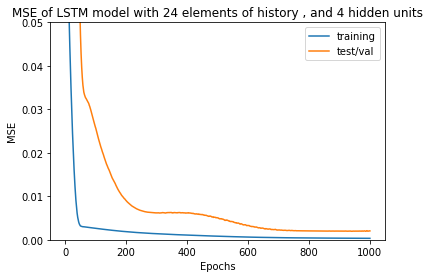

In [88]:
plt.plot(range(1,1001),output.history['loss'],label='training')
plt.plot(range(1,1001),output.history['val_loss'],label='test/val')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.ylim(0,0.05)
plt.title('MSE of LSTM model with 24 elements of history , and 4 hidden units')

Training data score: 9.51 RMSE
Test data score: 23.40 RMSE


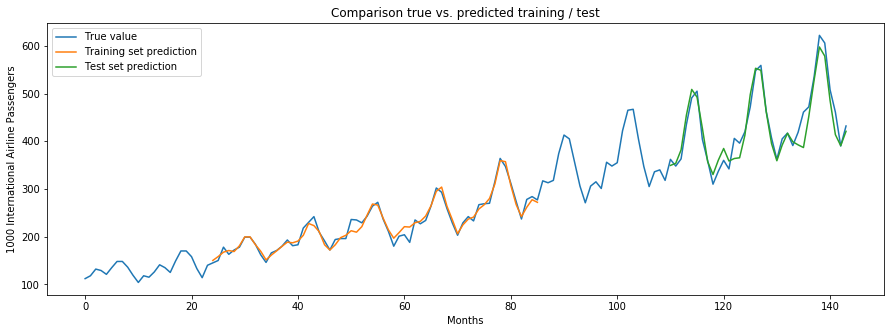

In [89]:
# Do the predictions
rmse_train, train_predict = predict_and_score(model, scaler,train_X, train_Y)
rmse_test, test_predict = predict_and_score(model, scaler,test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[train.shape[0] + window_size: , :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(range(144),scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

Wow, Now, it's much better! 